# Hyperparameter search results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from thesis_project.data_loading import load_session_ids
from thesis_project.evaluation.plots import (
    plot_binning_param_boxplots, plot_different_hyperparameters_all_sessions,
    plot_different_hyperparameters_per_session, plot_hyperparameter_boxplots)
from thesis_project.evaluation.result_loading import (get_best_parameter_dict,
                                                      get_best_values,
                                                      unify_results)
from thesis_project.settings import EXPERIMENT1_DIR, FIGURE_DIR, RESULT_DIR
from thesis_project.training.best_model_retraining import (INPUT_DIR,
                                                           RELEVANT_PARAMETERS)
from thesis_project.evaluation.result_loading import create_combined_results_table

ModuleNotFoundError: No module named 'thesis_project.evaluation.plots'

In [3]:
path = f"{RESULT_DIR}/final_results/selected_results"

## Check equal distribution
Sanity check whether result loading and truncation work correctly.

In [72]:
def check_equal_distribution(results, column):
    return results[column].value_counts()

In [73]:
# for comparison purposes, each model / task / session / binning param combination should include the same number of runs
# after setting the "limit_to_number" parameter

model_types = ["svm", "rnn", "trf"]
task_types = ["clf", "reg", "seq_clf", "seq_reg"] 


for task_type in task_types:
    for model_type in model_types:

        try:

            dir_prefix = f"{model_type}_{task_type}"
            print(dir_prefix)

            if task_type == "clf":
                label_names = ["syncat_labels", "semcat_labels", "labels_words"]
            elif task_type == "reg":
                label_names = ["labels_words"]
            else:
                label_names = ["sentences"]

            results = unify_results(path, dir_prefix=dir_prefix, label_names=label_names, limit_to_number=10)

            for label_name in label_names:
                if label_name in results:

                    print(f"{label_name} total: {len(results[label_name])}")
                    print(f'{label_name} binning_params: {check_equal_distribution(results[label_name], "binning_params")}')
                    print(f'{label_name} session_id: {check_equal_distribution(results[label_name], "session_id")}')

                    print()
        except Exception as e:
            print(e)
            ...
        print()

svm_clf
syncat_labels total: 240
syncat_labels binning_params: binning_params
50_size_None_sd    60
50_size_2_sd       60
20_size_None_sd    60
20_size_2_sd       60
Name: count, dtype: int64
syncat_labels session_id: session_id
20221117    40
20221121    40
20221114    40
20221109    40
20221123    40
20221116    40
Name: count, dtype: int64

semcat_labels total: 240
semcat_labels binning_params: binning_params
50_size_None_sd    60
50_size_2_sd       60
20_size_None_sd    60
20_size_2_sd       60
Name: count, dtype: int64
semcat_labels session_id: session_id
20221117    40
20221121    40
20221114    40
20221109    40
20221123    40
20221116    40
Name: count, dtype: int64

labels_words total: 240
labels_words binning_params: binning_params
50_size_None_sd    60
50_size_2_sd       60
20_size_None_sd    60
20_size_2_sd       60
Name: count, dtype: int64
labels_words session_id: session_id
20221117    40
20221121    40
20221114    40
20221109    40
20221123    40
20221116    40
Name: co

## Result tables

### Best classification accuracies

In [14]:
task_name = "clf"
metric_name = "mean_test_accuracy"
ascending = False
label_names = ["syncat_labels", "semcat_labels", "labels_words"]
limit_to_number = 10

results = {}

for model_name in ["svm", "rnn", "trf"]:
    results[model_name] = get_best_values(f"{model_name}_{task_name}",
                                            metric_name=metric_name, label_names=label_names, limit_to_number=limit_to_number, ascending=ascending)

In [15]:
result_dict = create_combined_results_table(results, metric_name, label_names)

model_names = ["svm", "rnn", "trf"]
label_names = ["syncat_labels", "semcat_labels", "labels_words"]

combined_df = {"session_id": []}
combined_df = {**combined_df, **{f"{label_name}_{model_name}": [] for model_name in model_names for label_name in label_names}}
combined_df["session_id"] = []

session_ids = sorted(load_session_ids(EXPERIMENT1_DIR))

for i, session_id in enumerate(session_ids):

    combined_df["session_id"].append(session_id)

    for label_name in label_names:

            for model_name in model_names:
                combined_df[f"{label_name}_{model_name}"].append(result_dict[label_name][model_name][i])

In [16]:
pd.DataFrame(combined_df)

session_id  syncat_labels_svm  semcat_labels_svm  labels_words_svm  \
0   20221109           0.689516           0.757094          0.533219   
1   20221114           0.676067           0.739933          0.343467   
2   20221116           0.712000           0.640185          0.314831   
3   20221117           0.782646           0.716738          0.363877   
4   20221121           0.669354           0.636308          0.305723   
5   20221123           0.594701           0.667009          0.407692   

   syncat_labels_rnn  semcat_labels_rnn  labels_words_rnn  syncat_labels_trf  \
0           0.711681           0.757550          0.544444           0.749858   
1           0.702000           0.791000          0.354667           0.718667   
2           0.732615           0.670769          0.339077           0.740308   
3           0.889846           0.748000          0.370462           0.810769   
4           0.669231           0.591385          0.313846           0.724000   
5           0.620513           0.723647          0.433048           0.627350   

   semcat_labels_trf  labels_words_trf  
0           0.801994          0.613675  
1           0.742333          0.396000  
2           0.724615          0.369231  
3           0.740000          0.401231  
4           0.622462          0.348000  
5           0.657265          0.448433

### Best regression MSE

In [12]:
task_name = "reg"
metric_name = "mean_test_mse"
label_names = ["labels_words"]
ascending = True
limit_to_number = 10

results = {}

for model_name in ["svm", "rnn", "trf"]:
     results[model_name] = get_best_values(f"{model_name}_{task_name}",
                                            metric_name=metric_name, label_names=label_names, limit_to_number=limit_to_number, ascending=ascending)
     
result_dict = create_combined_results_table(results, metric_name, label_names)

pd.DataFrame(result_dict["labels_words"]).sort_values(by="session_id")

session_id       svm       rnn       trf
0   20221109  0.248268  0.727989  0.244899
1   20221114  0.211095  0.735564  0.231227
2   20221116  0.204314  0.786227  0.206013
3   20221117  0.273089  0.738144  0.295863
4   20221121  0.290473  0.822799  0.307111
5   20221123  0.300847  0.856704  0.294670

## Classification plots

In [74]:
label_names = ["syncat_labels", "semcat_labels", "labels_words"]

### SVM

In [75]:
model_name = "svm"
task_name = "clf"
dir_prefix = f"{model_name}_{task_name}"
results = unify_results(path, dir_prefix=dir_prefix, limit_to_number=10)

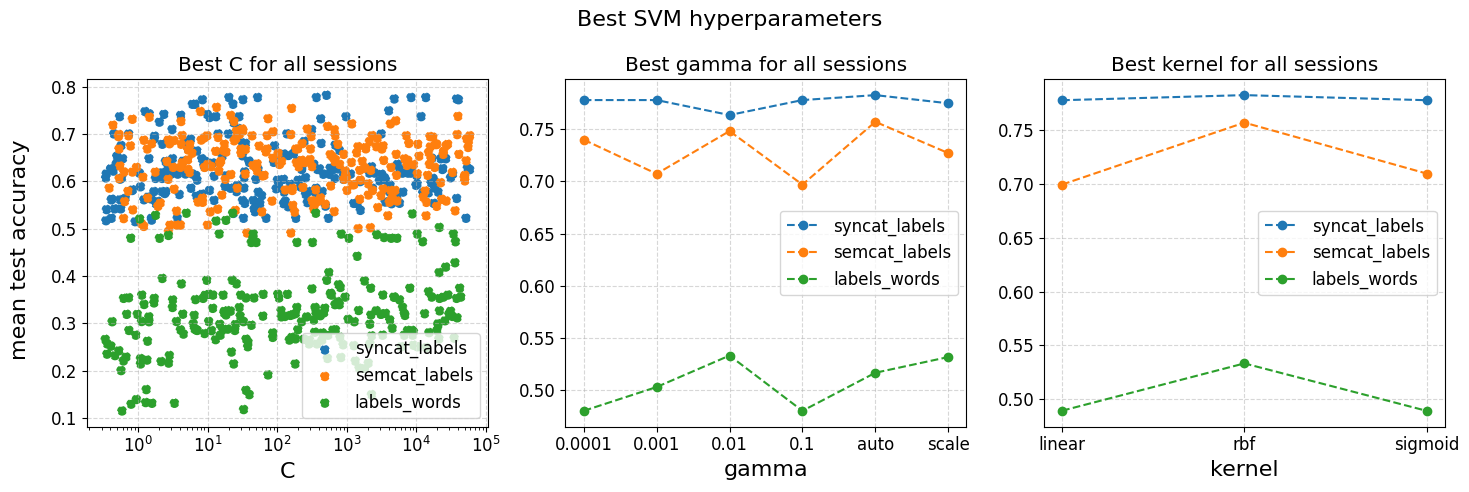

In [76]:
plot_different_hyperparameters_all_sessions(results, model_name, task_name, output_type="test")

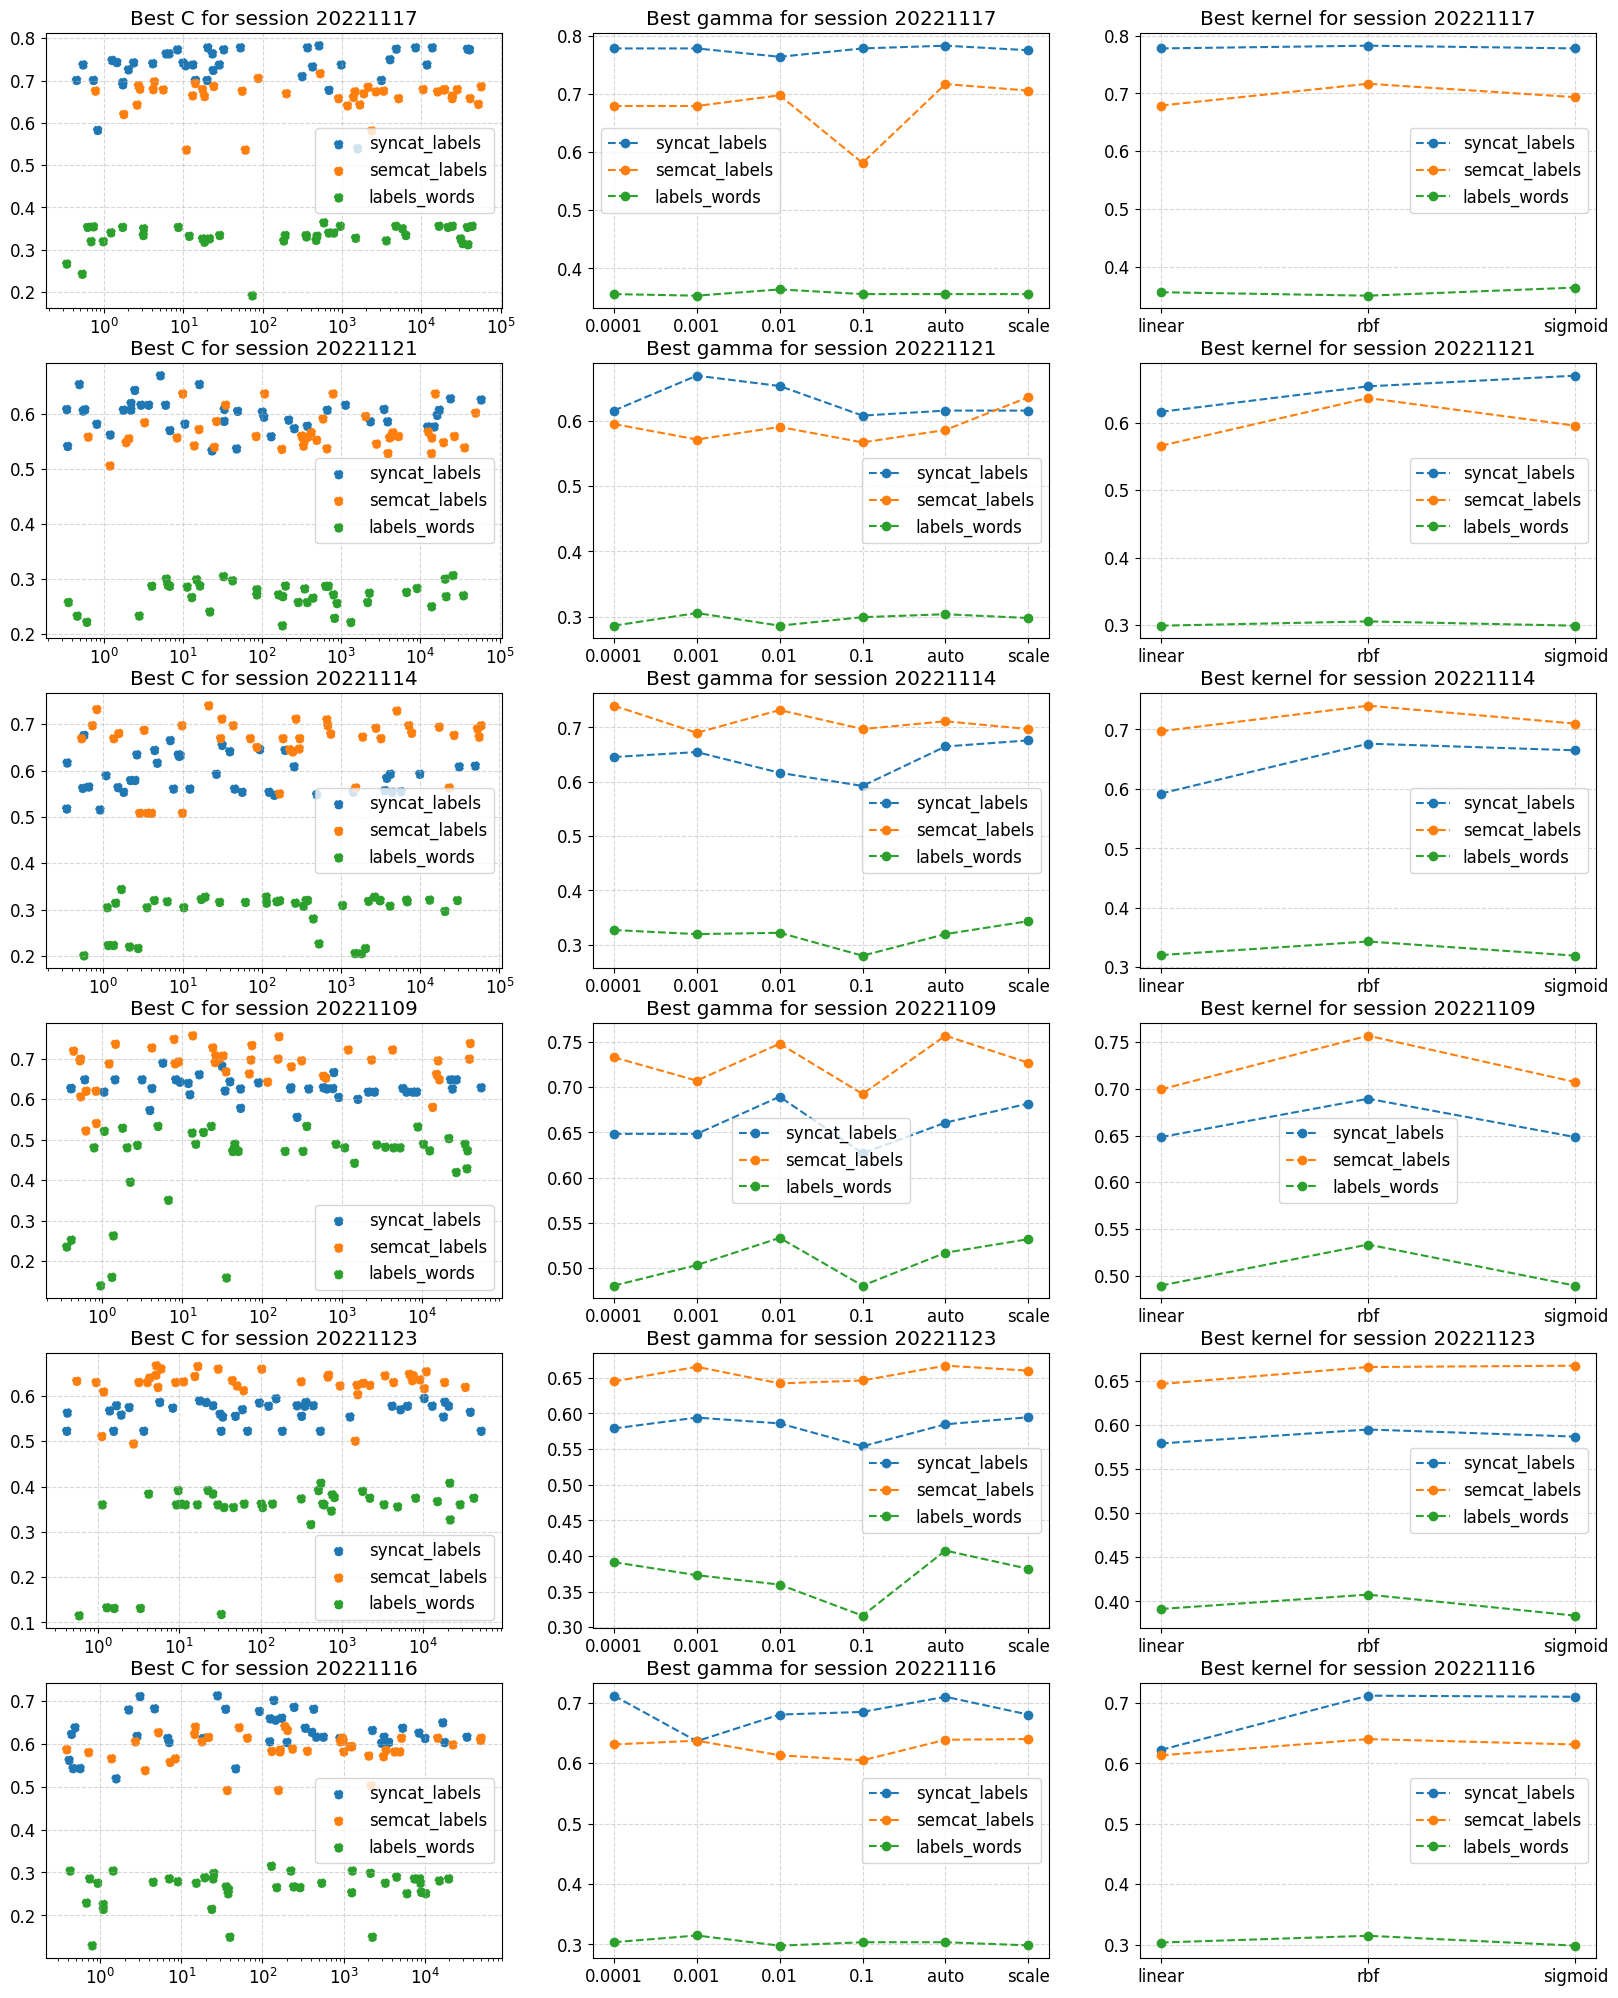

In [77]:
plot_different_hyperparameters_per_session(results, model_name, task_name, output_type="test")

### RNN

In [78]:
model_name = "rnn"
task_name = "clf"
dir_prefix = f"{model_name}_{task_name}"
results = unify_results(path, dir_prefix=dir_prefix, limit_to_number=10)

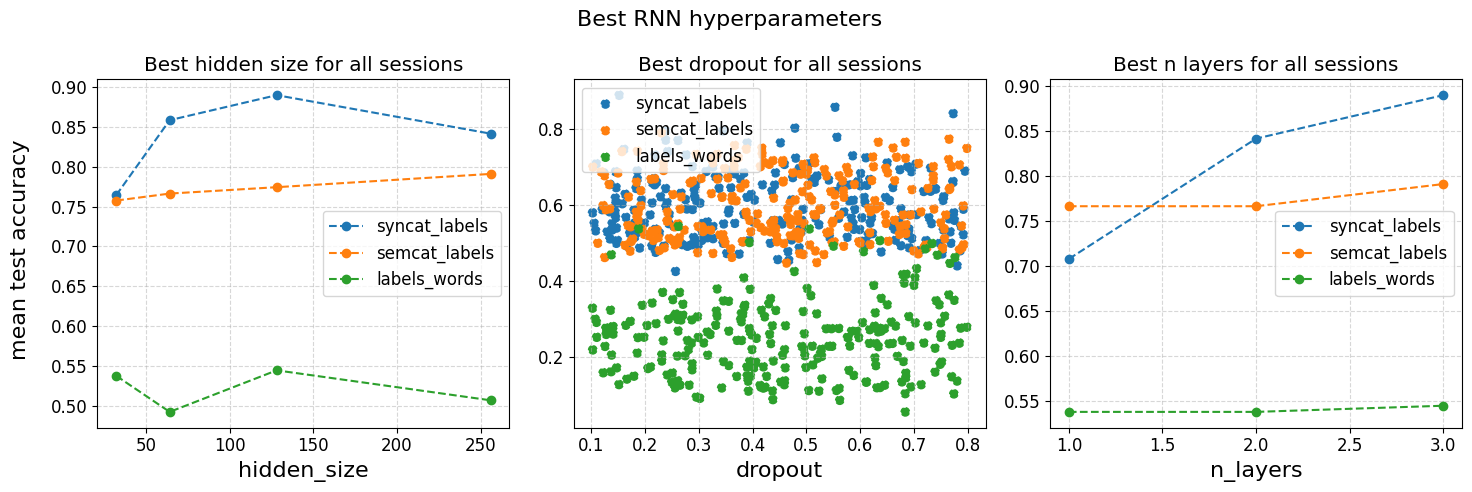

In [79]:
plot_different_hyperparameters_all_sessions(results, model_name, task_name, output_type="test")

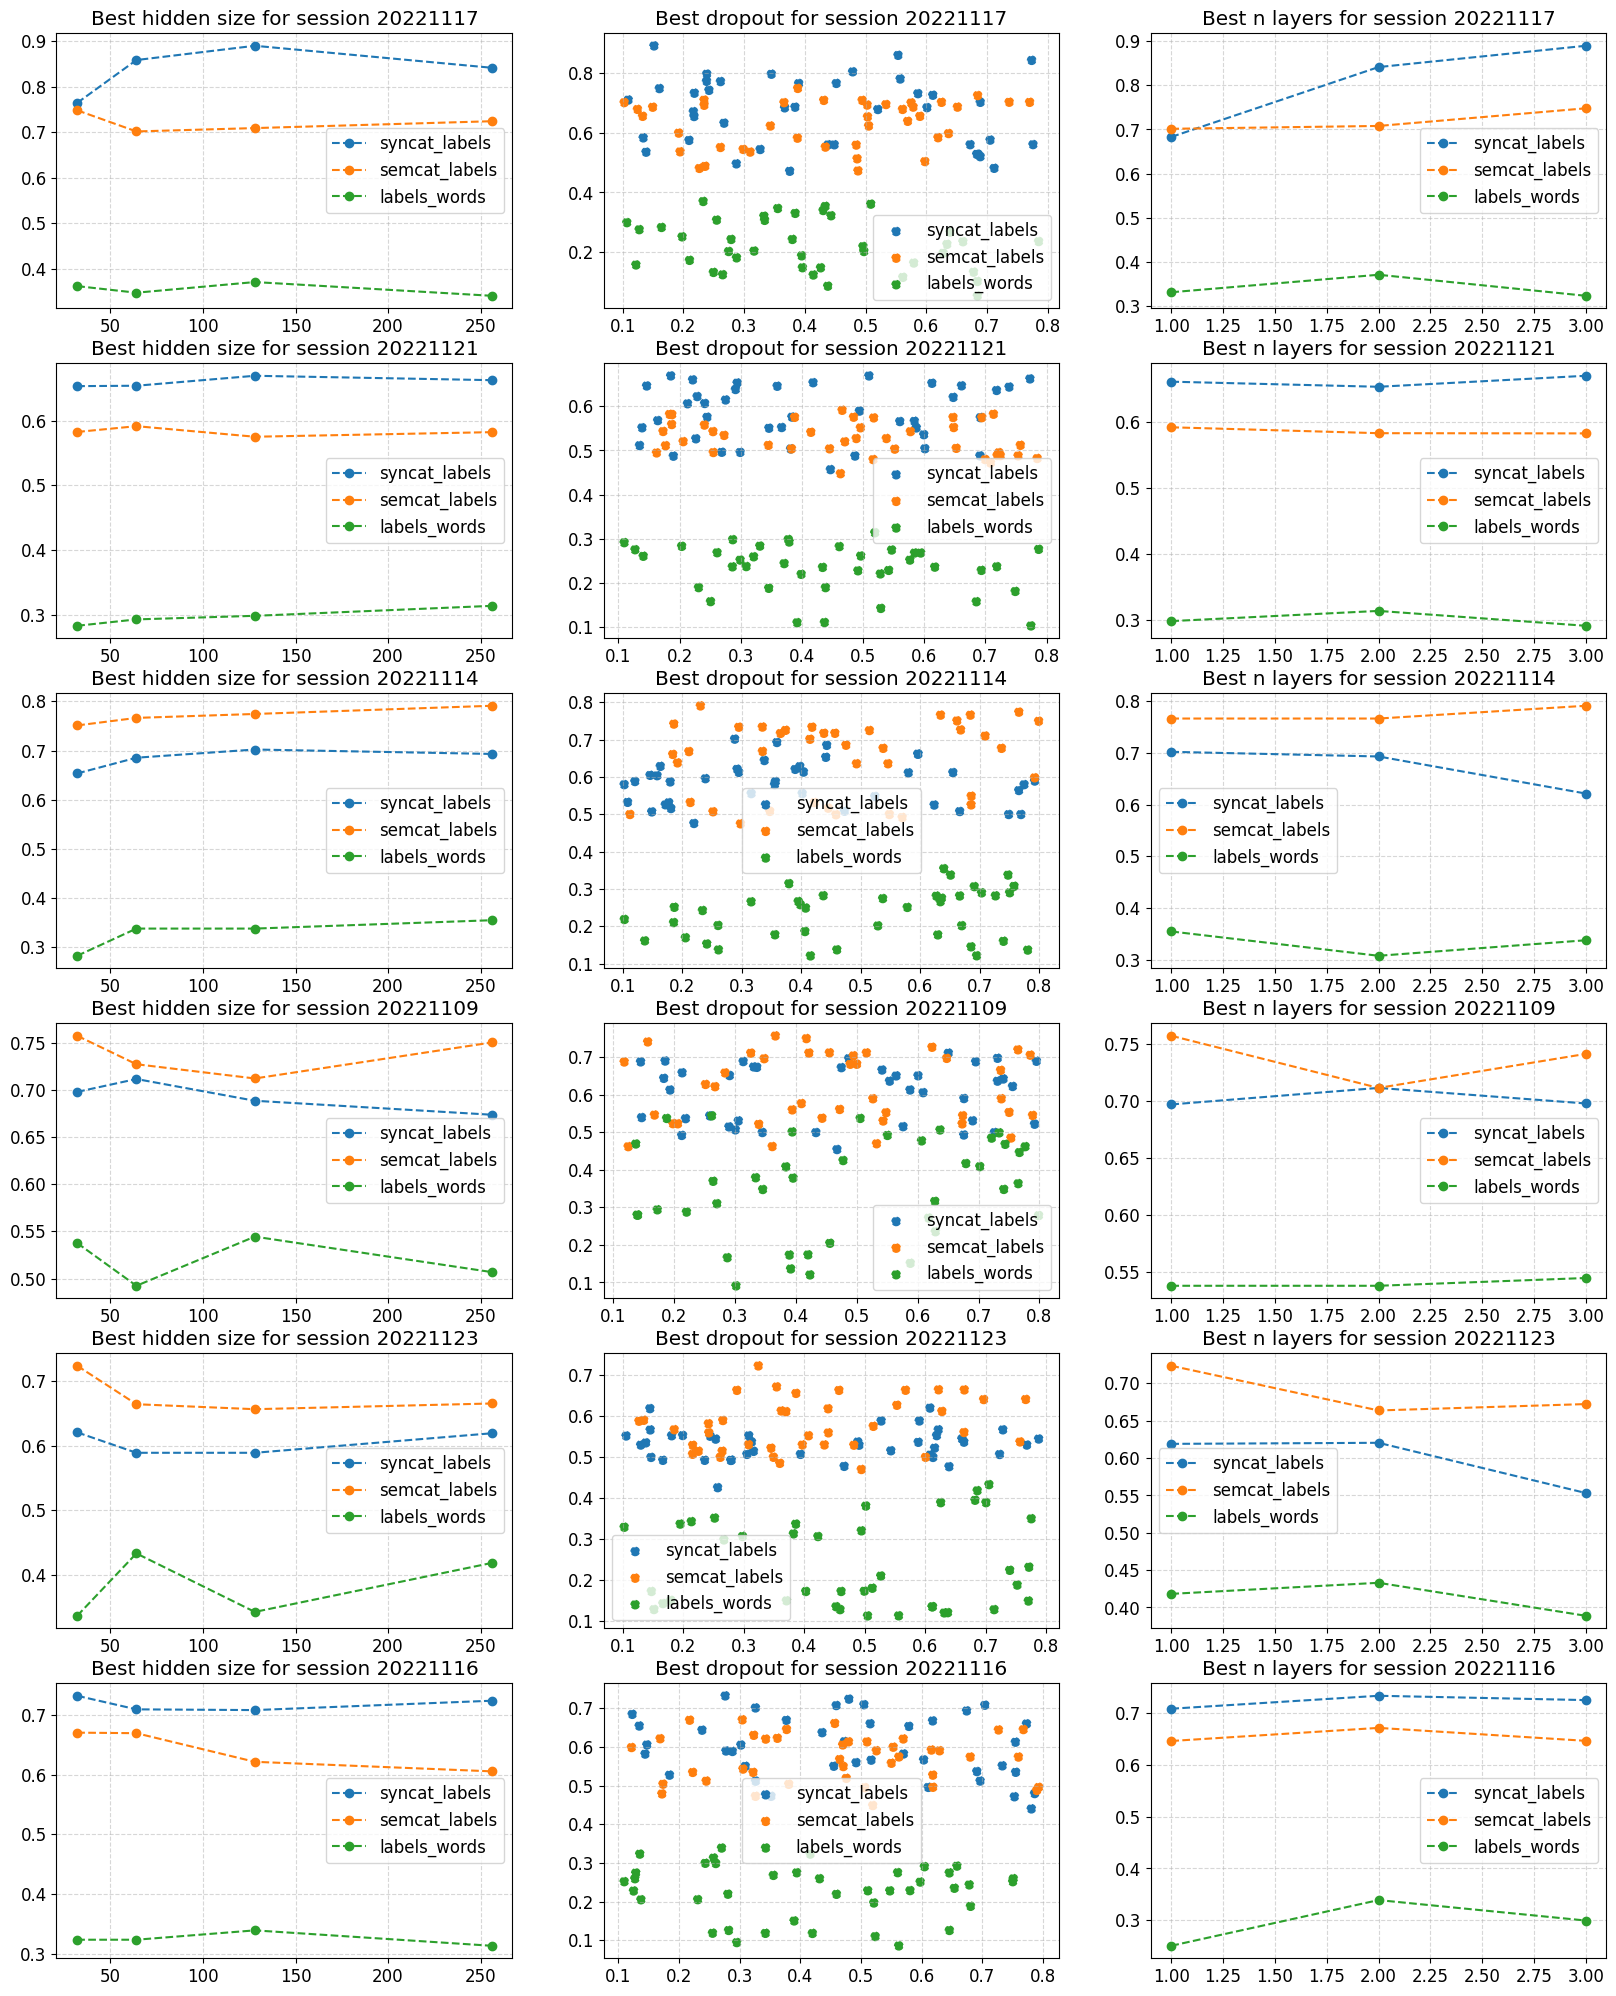

In [80]:
plot_different_hyperparameters_per_session(results, model_name, task_name, output_type="test")

### TRF

In [81]:
model_name = "trf"
task_name = "clf"
dir_prefix = f"{model_name}_{task_name}"
results = unify_results(path, dir_prefix=dir_prefix, limit_to_number=10)

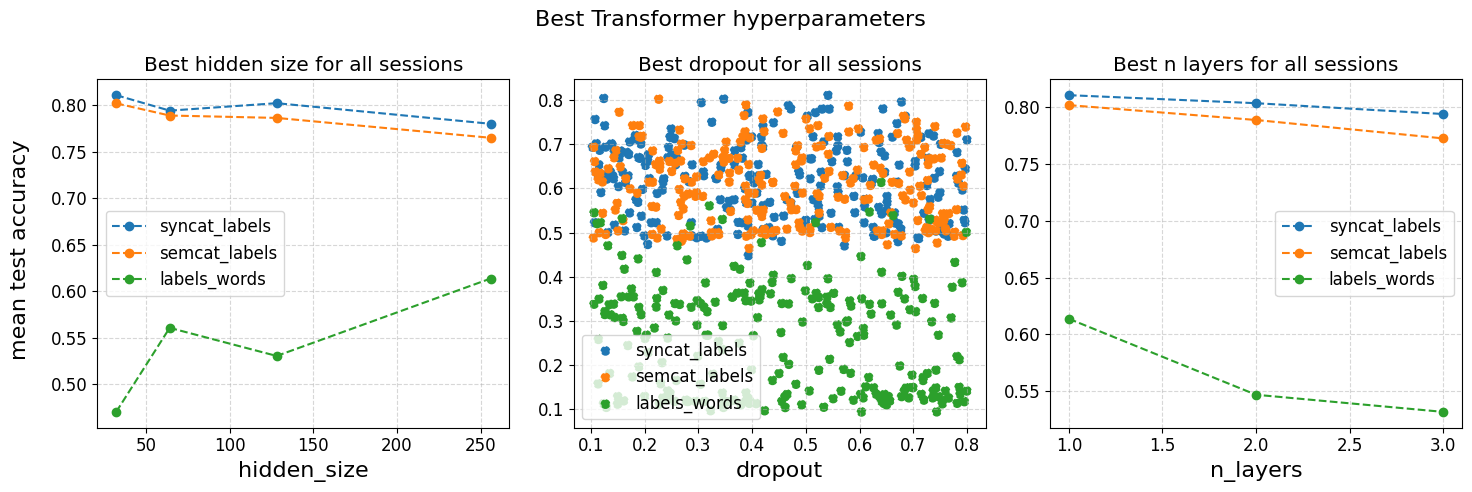

In [82]:
plot_different_hyperparameters_all_sessions(results, model_name, task_name, output_type="test")

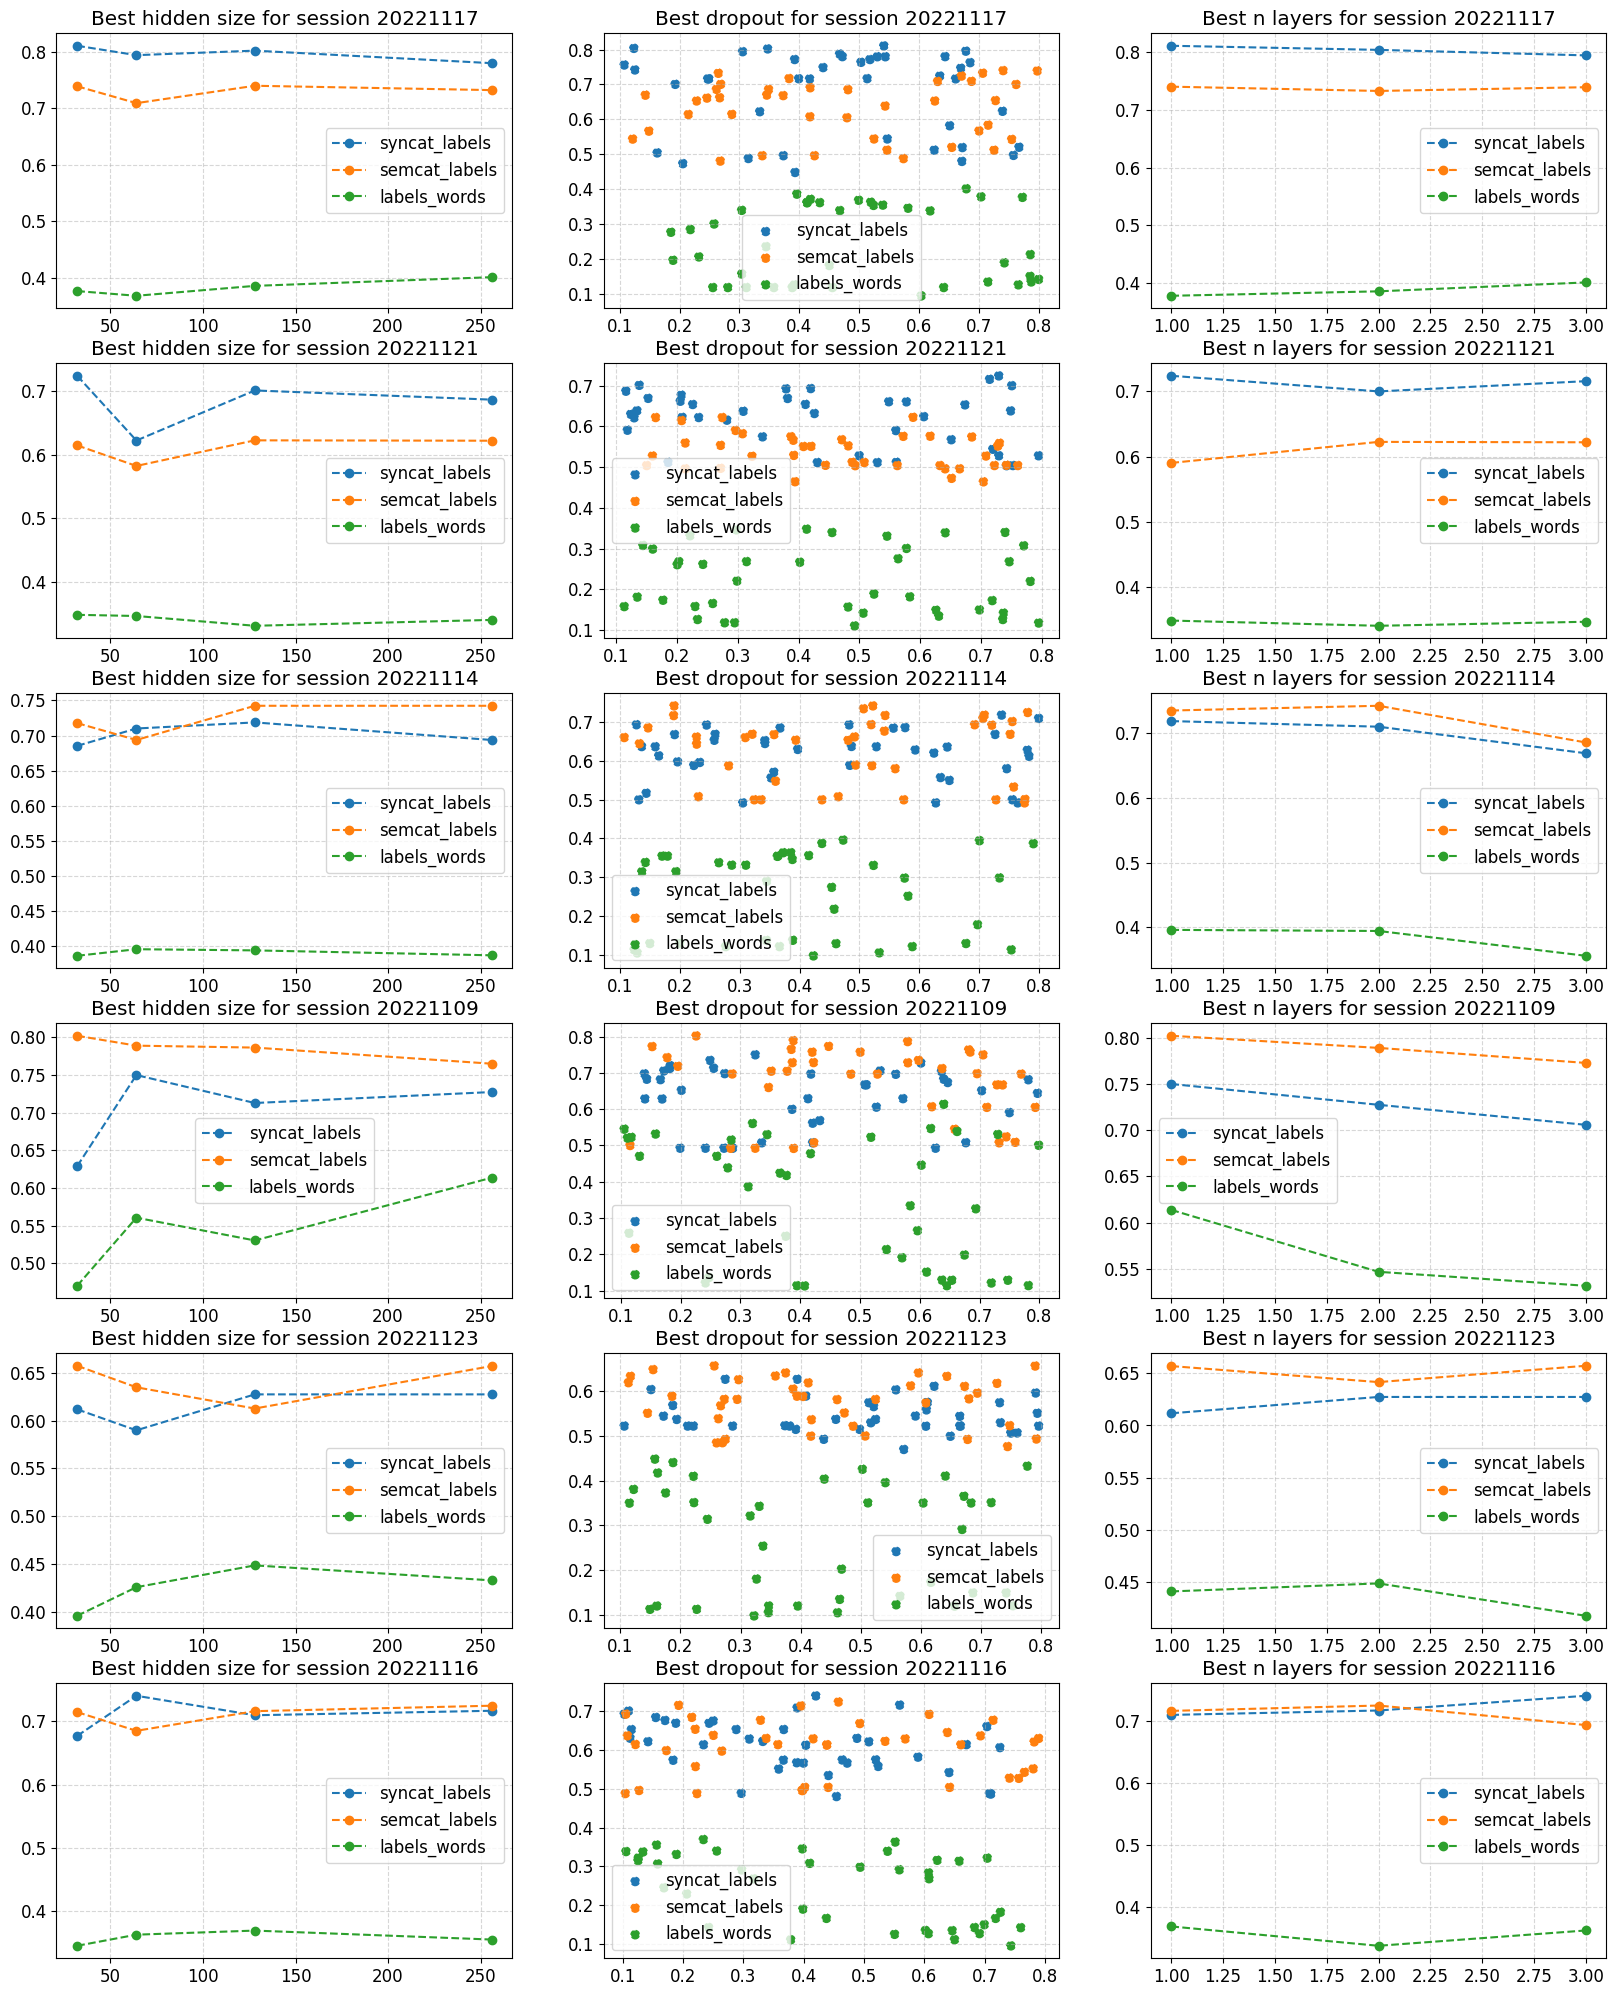

In [83]:
plot_different_hyperparameters_per_session(results, model_name, task_name, output_type="test")

## Regression plots

### SVM

In [84]:
model_name = "svm"
task_name = "reg"
dir_prefix = f"{model_name}_{task_name}"
results = unify_results(path, dir_prefix=dir_prefix, label_names=["labels_words"], limit_to_number=10)

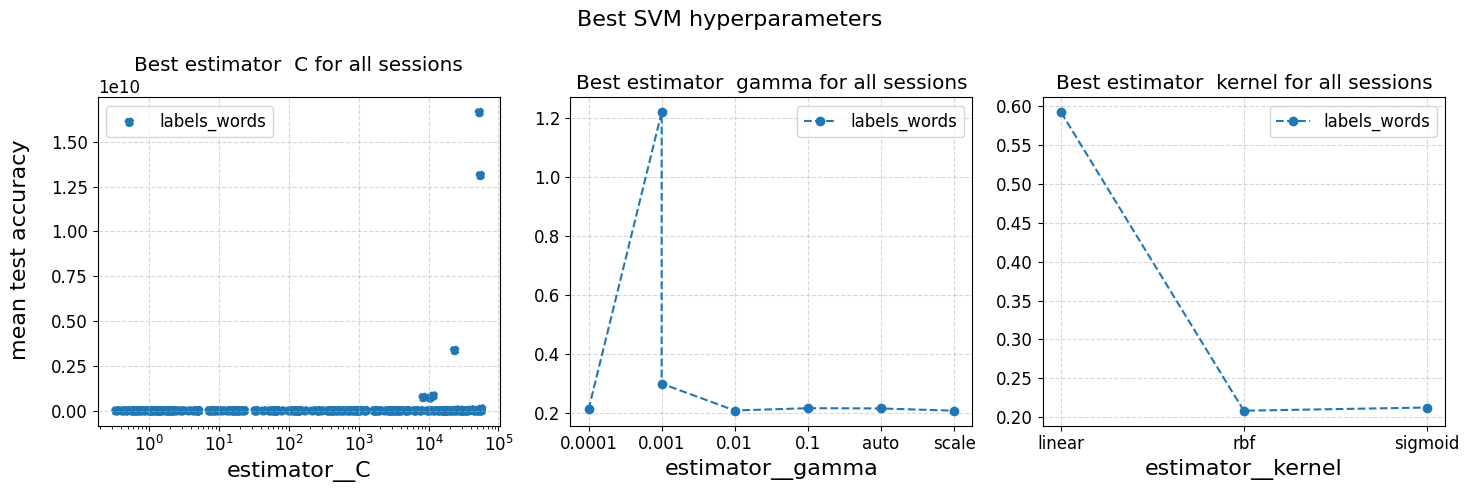

In [85]:
plot_different_hyperparameters_all_sessions(results, model_name, task_name, metric_name="mean_test_mse", ascending=True, output_type="test")

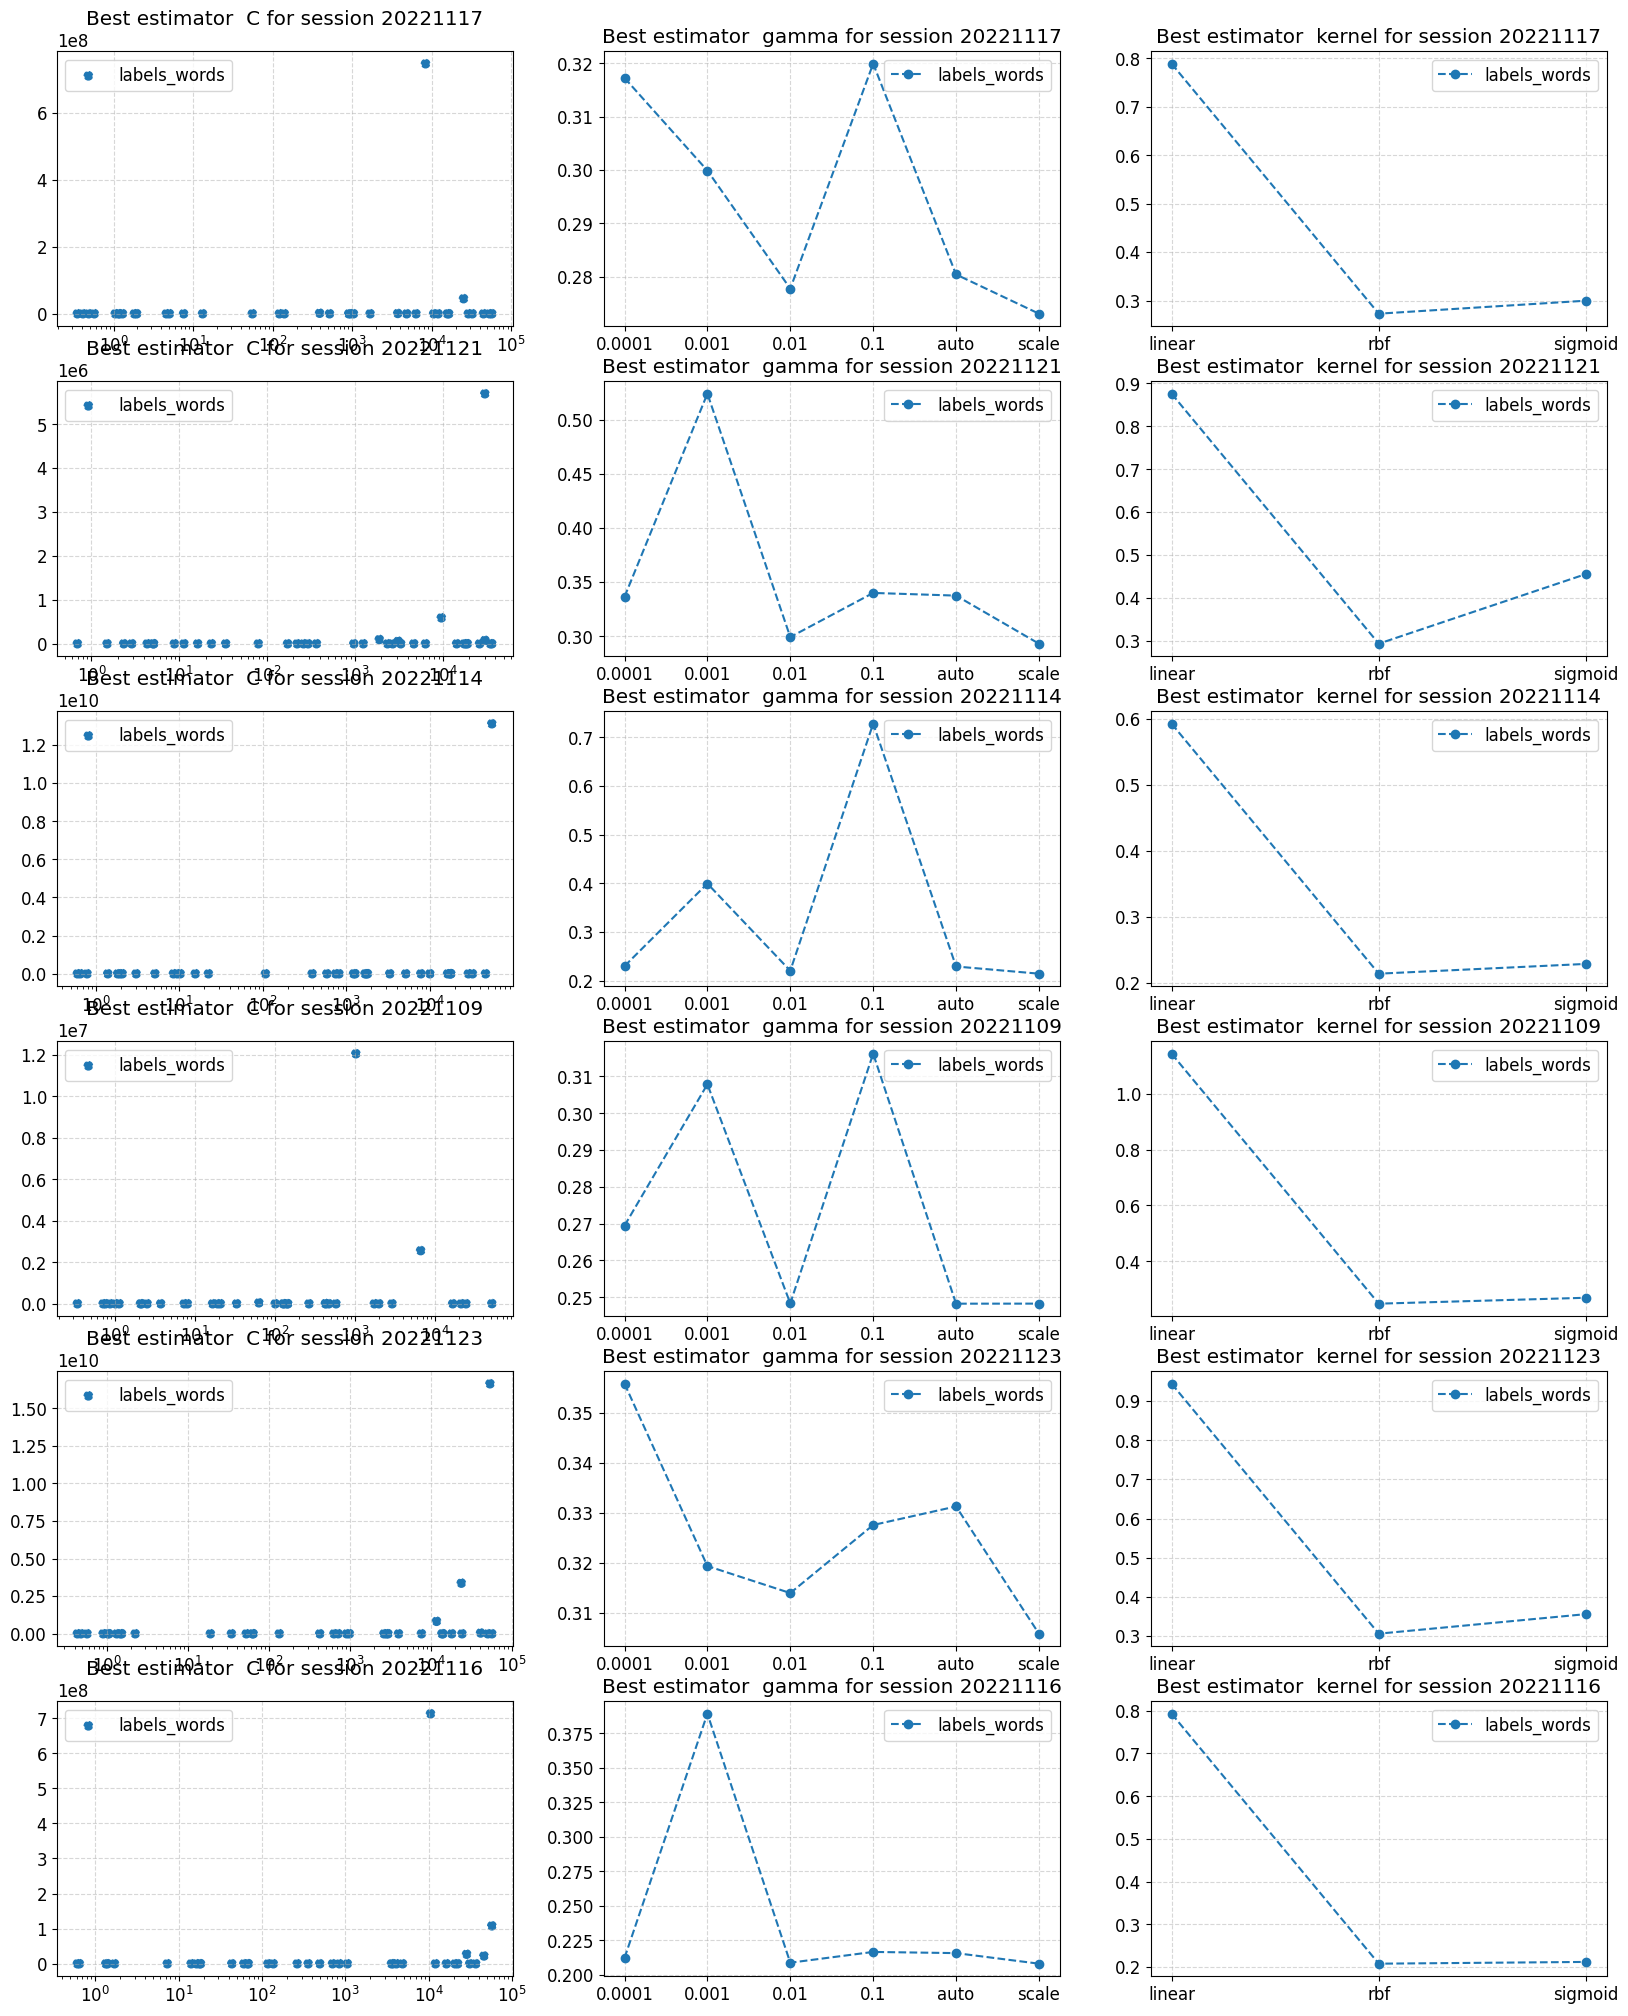

In [86]:
plot_different_hyperparameters_per_session(results, model_name, task_name, metric_name="mean_test_mse", ascending=True, output_type="test")

### RNN

In [87]:
model_name = "rnn"
task_name = "reg"
dir_prefix = f"{model_name}_{task_name}"
results = unify_results(path, dir_prefix=dir_prefix, label_names=["labels_words"], limit_to_number=10)

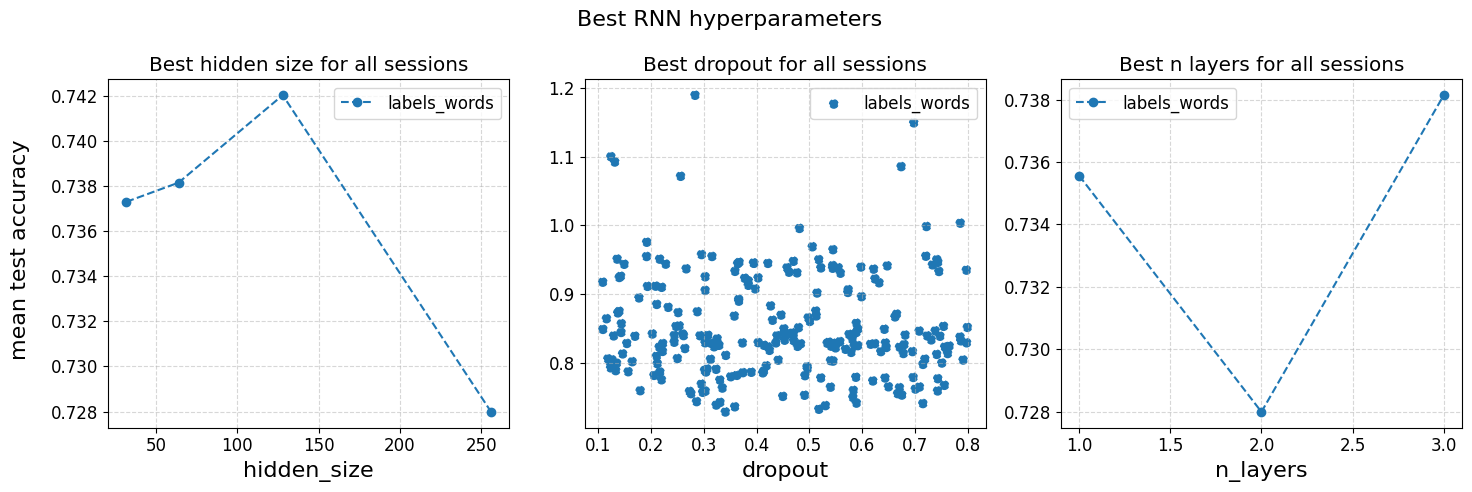

In [88]:
plot_different_hyperparameters_all_sessions(results, model_name, task_name, metric_name="mean_test_mse", ascending=True, output_type="test")

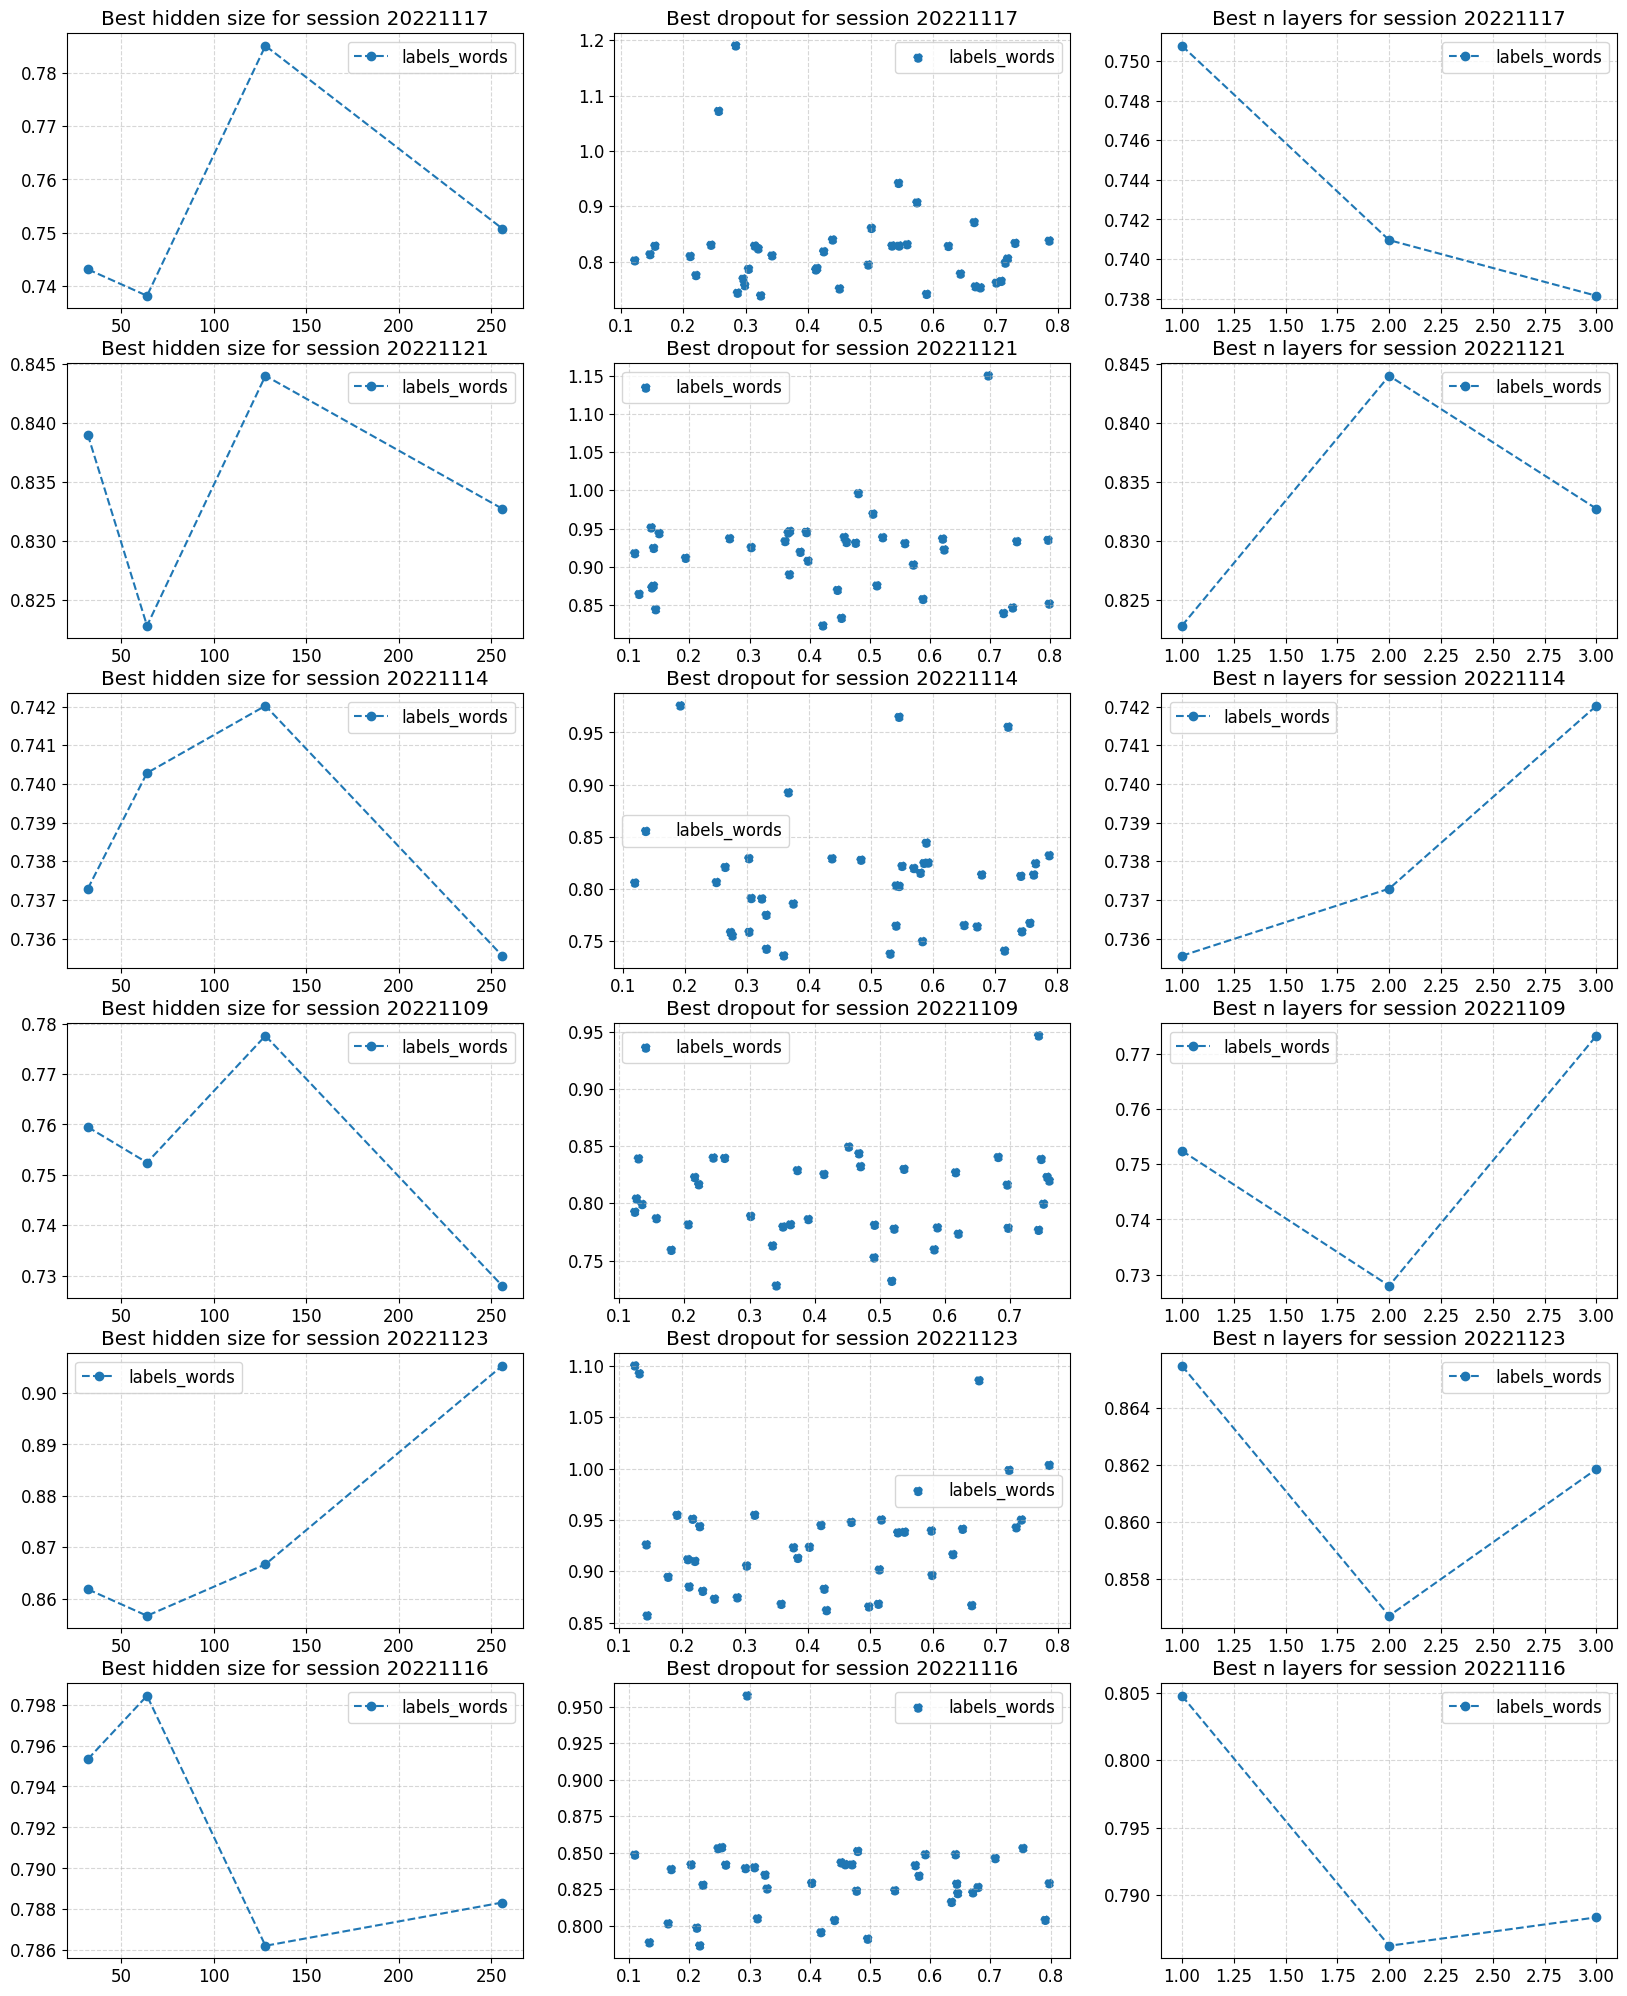

In [89]:
plot_different_hyperparameters_per_session(results, model_name, task_name, metric_name="mean_test_mse", ascending=True, output_type="test")

### TRF

In [90]:
model_name = "trf"
task_name = "reg"
dir_prefix = f"{model_name}_{task_name}"
results = unify_results(path, dir_prefix=dir_prefix, label_names=["labels_words"], limit_to_number=10)

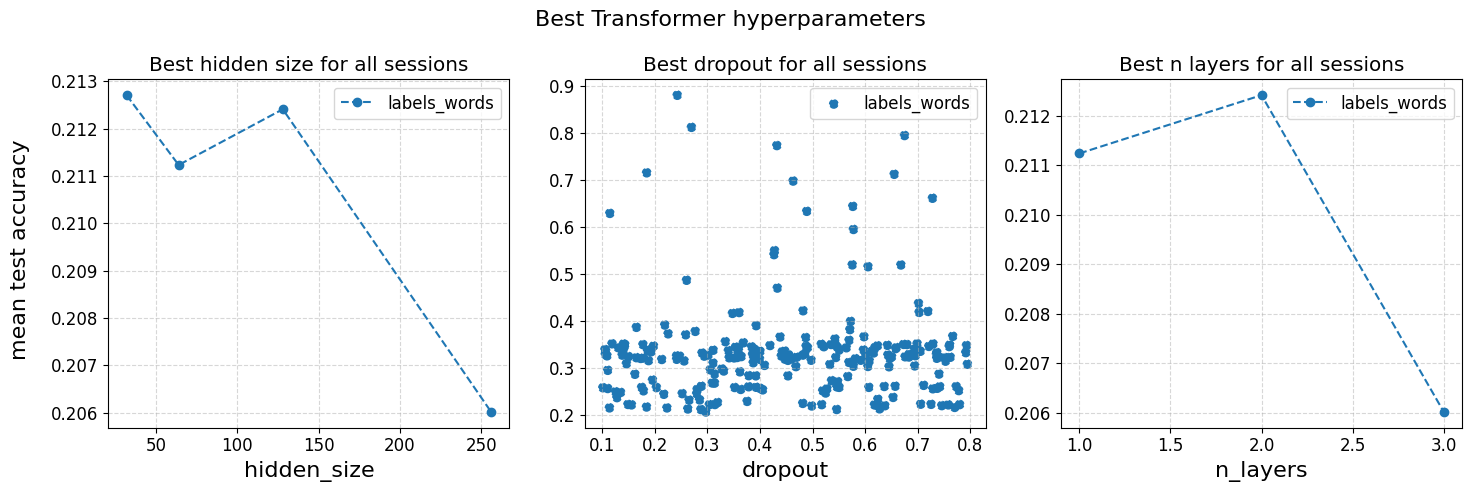

In [91]:
plot_different_hyperparameters_all_sessions(results, model_name, task_name, metric_name="mean_test_mse", ascending=True, output_type="test")

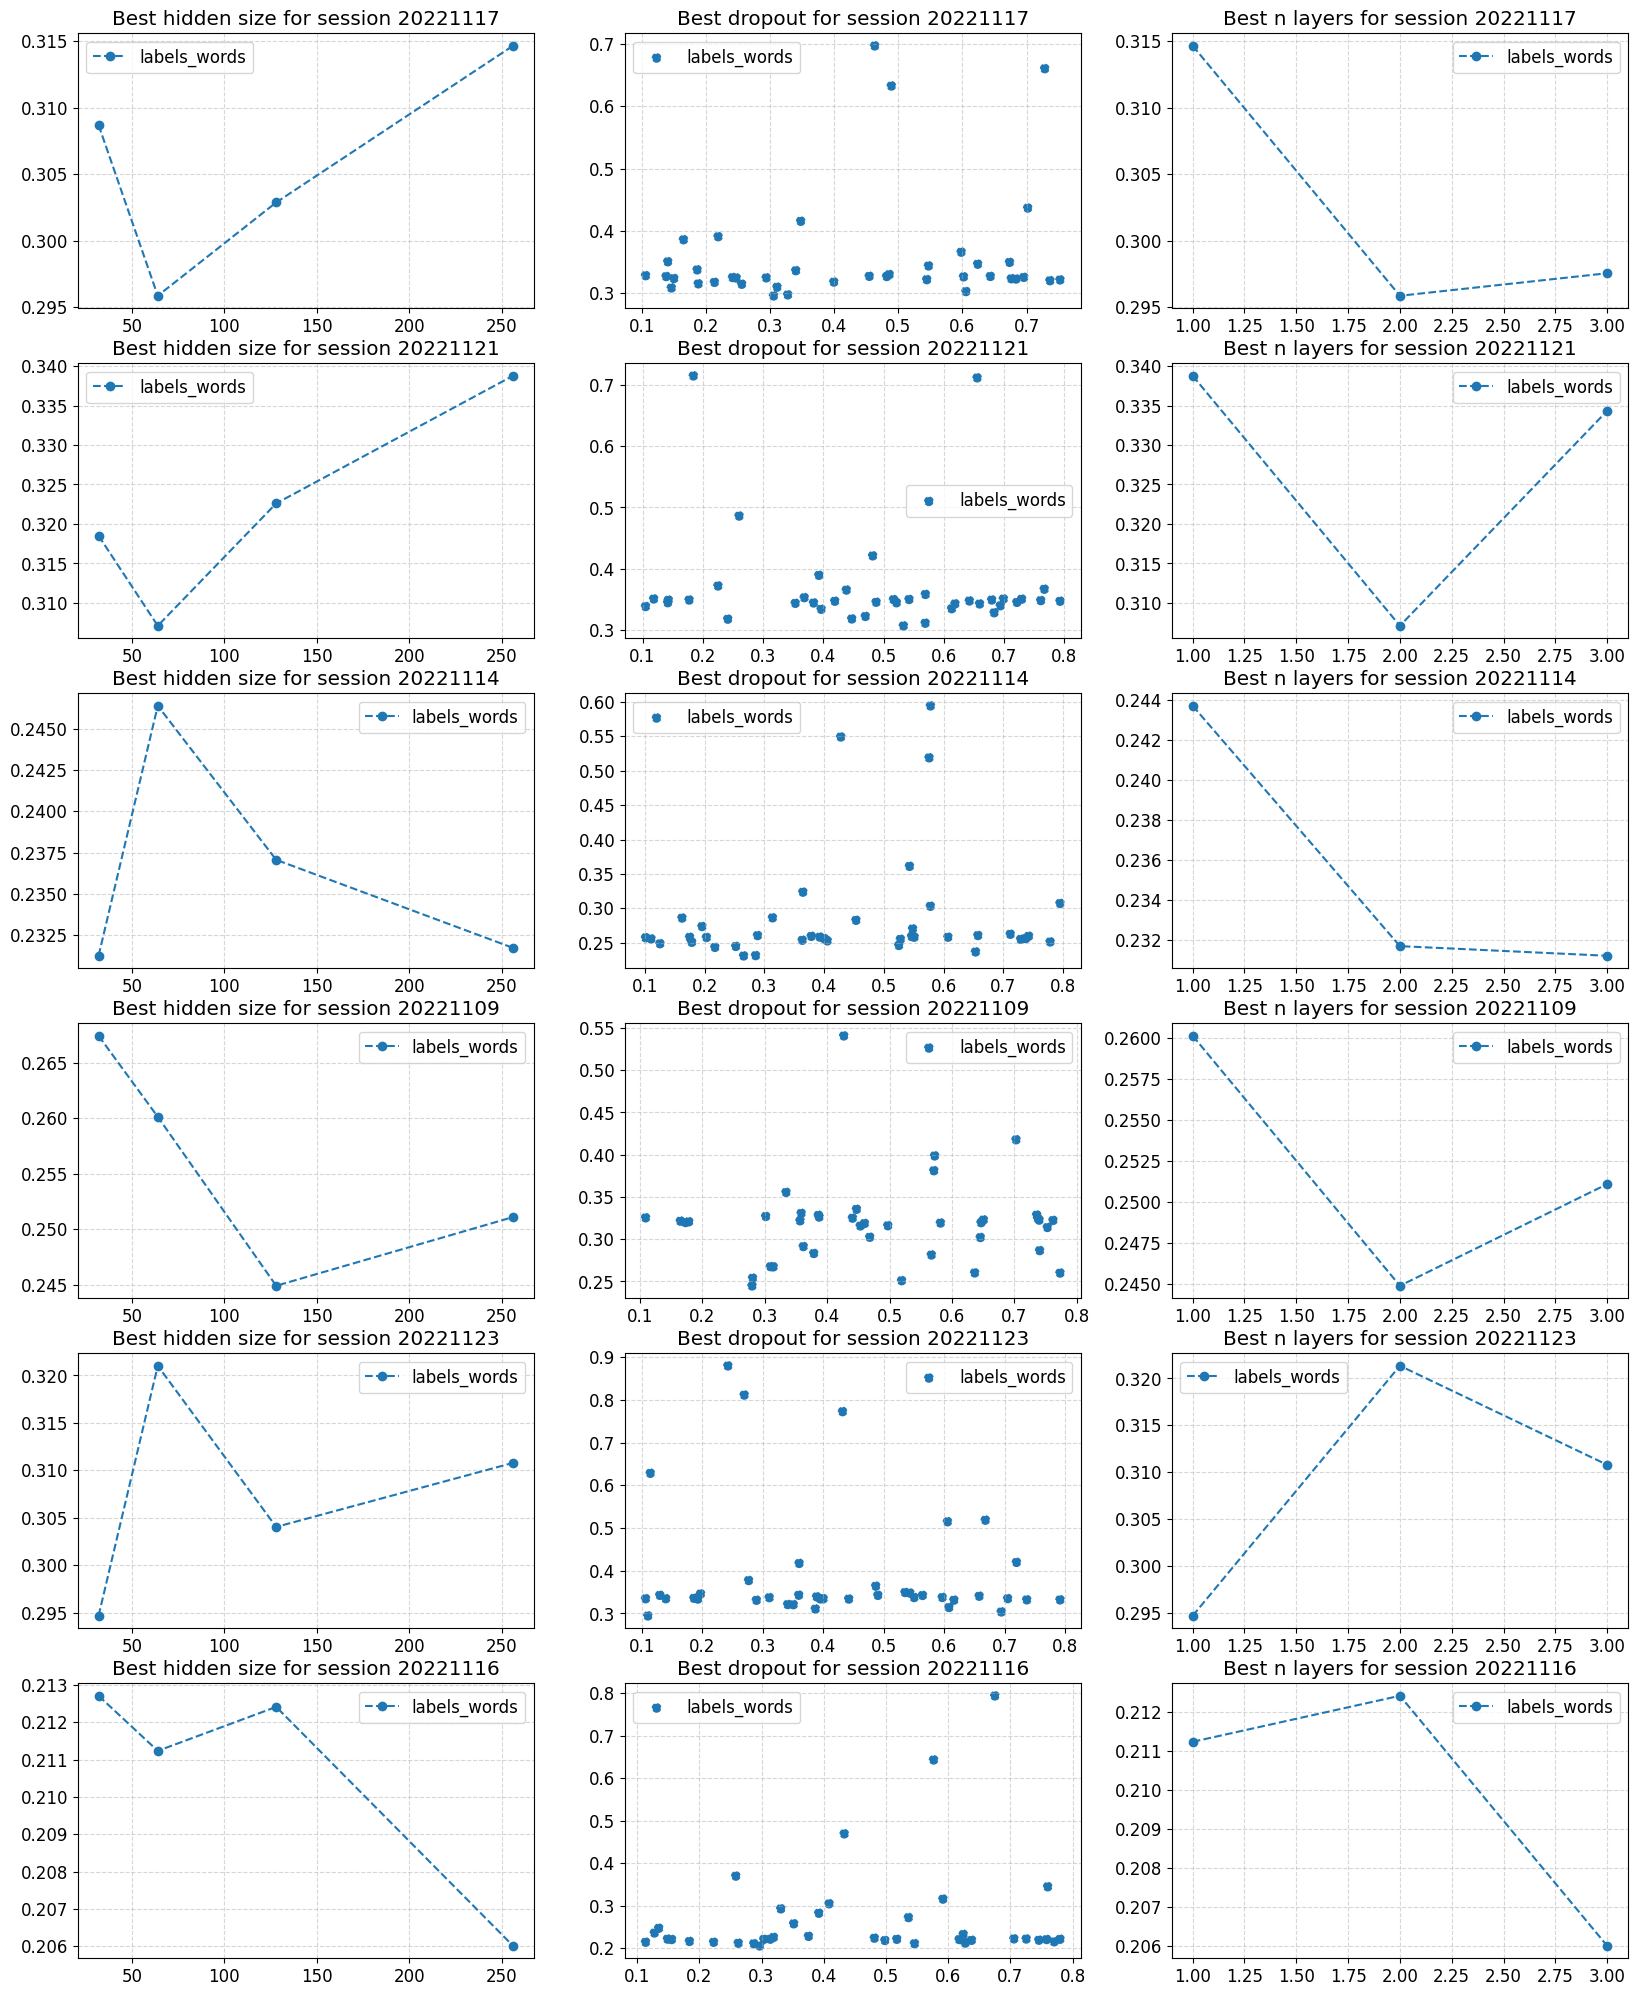

In [92]:
plot_different_hyperparameters_per_session(results, model_name, task_name, metric_name="mean_test_mse", ascending=True, output_type="test")

## Sequence processing

### RNN

In [93]:
model_name = "rnn"
task_name = "seq_clf"
dir_prefix = f"{model_name}_{task_name}"
results = unify_results(path, dir_prefix=dir_prefix, label_names=["sentences"], limit_to_number=20)

In [94]:
df = get_best_values(dir_prefix, metric_name="mean_test_loss", additional_metrics=[], label_names=["sentences"], ascending=True)
df

session_id  sentences_mean_test_loss
0    20240708                  2.148799

<module 'matplotlib.pyplot' from '/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

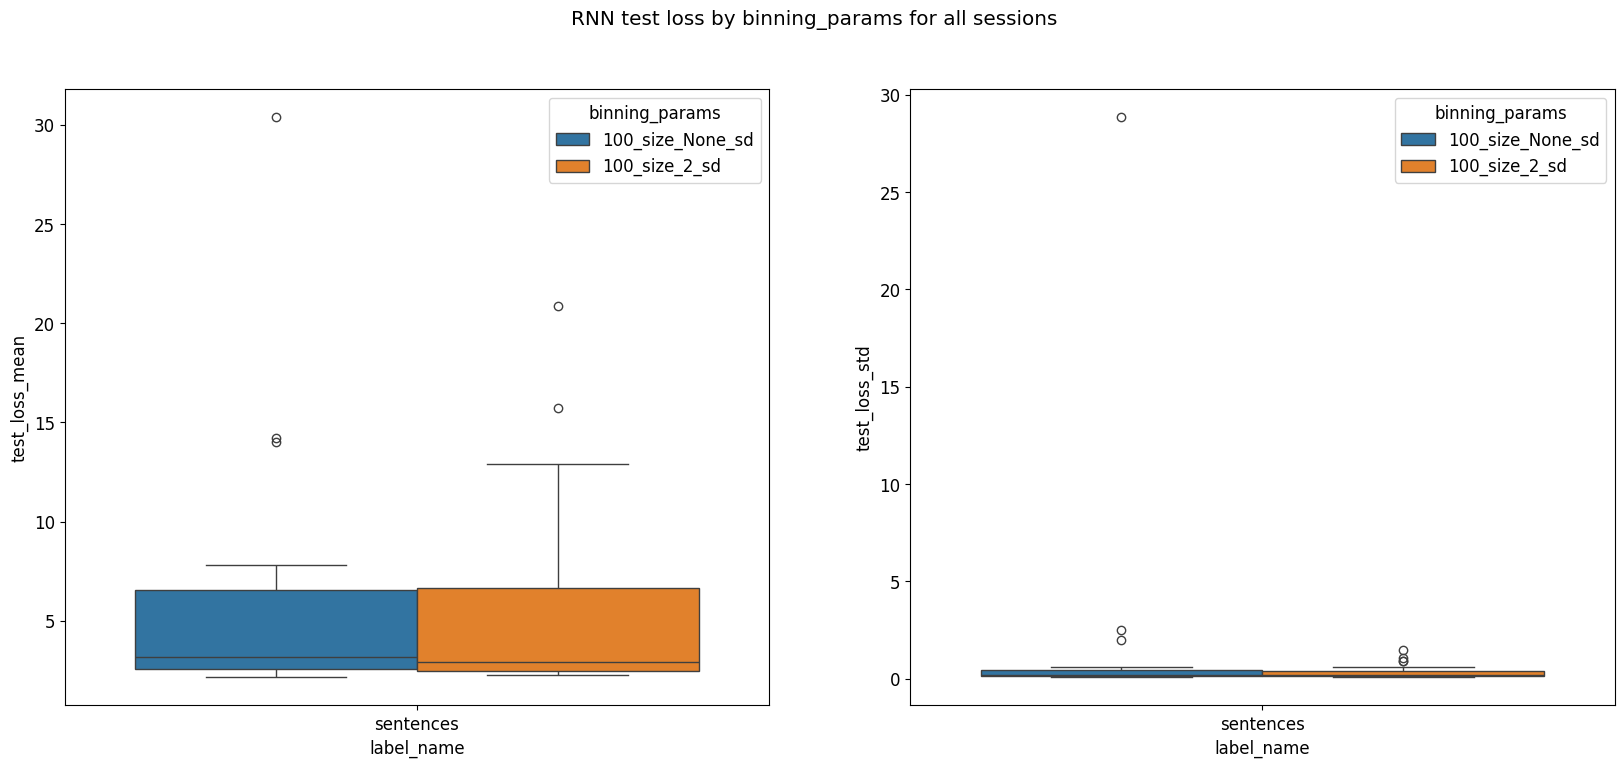

In [95]:
plot_hyperparameter_boxplots(results, "binning_params", "test", "loss", dir_prefix, label_names=["sentences"])

<module 'matplotlib.pyplot' from '/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

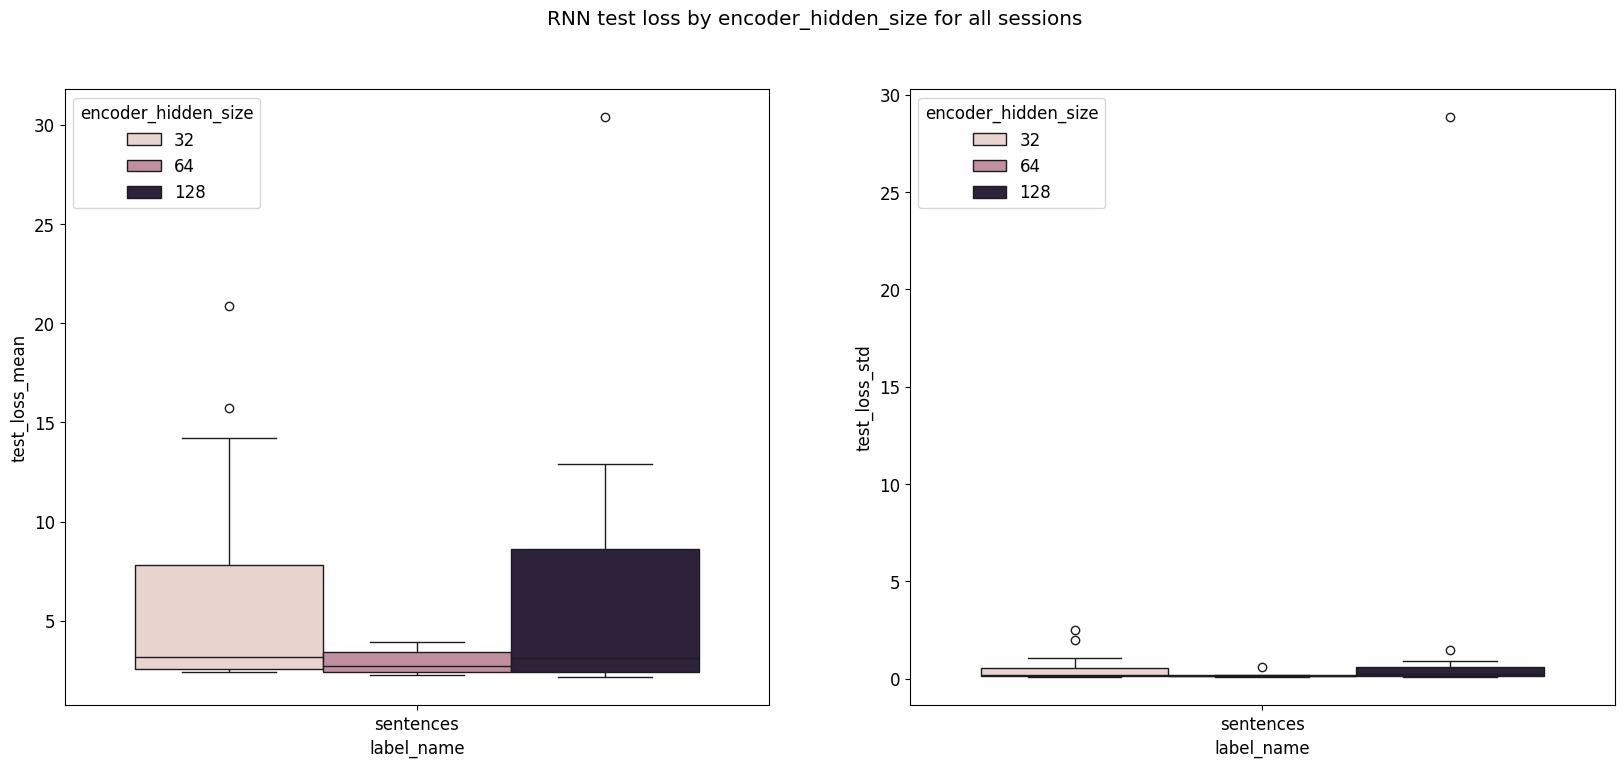

In [96]:
plot_hyperparameter_boxplots(results, "encoder_hidden_size", "test", "loss", dir_prefix, label_names=["sentences"])

<module 'matplotlib.pyplot' from '/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

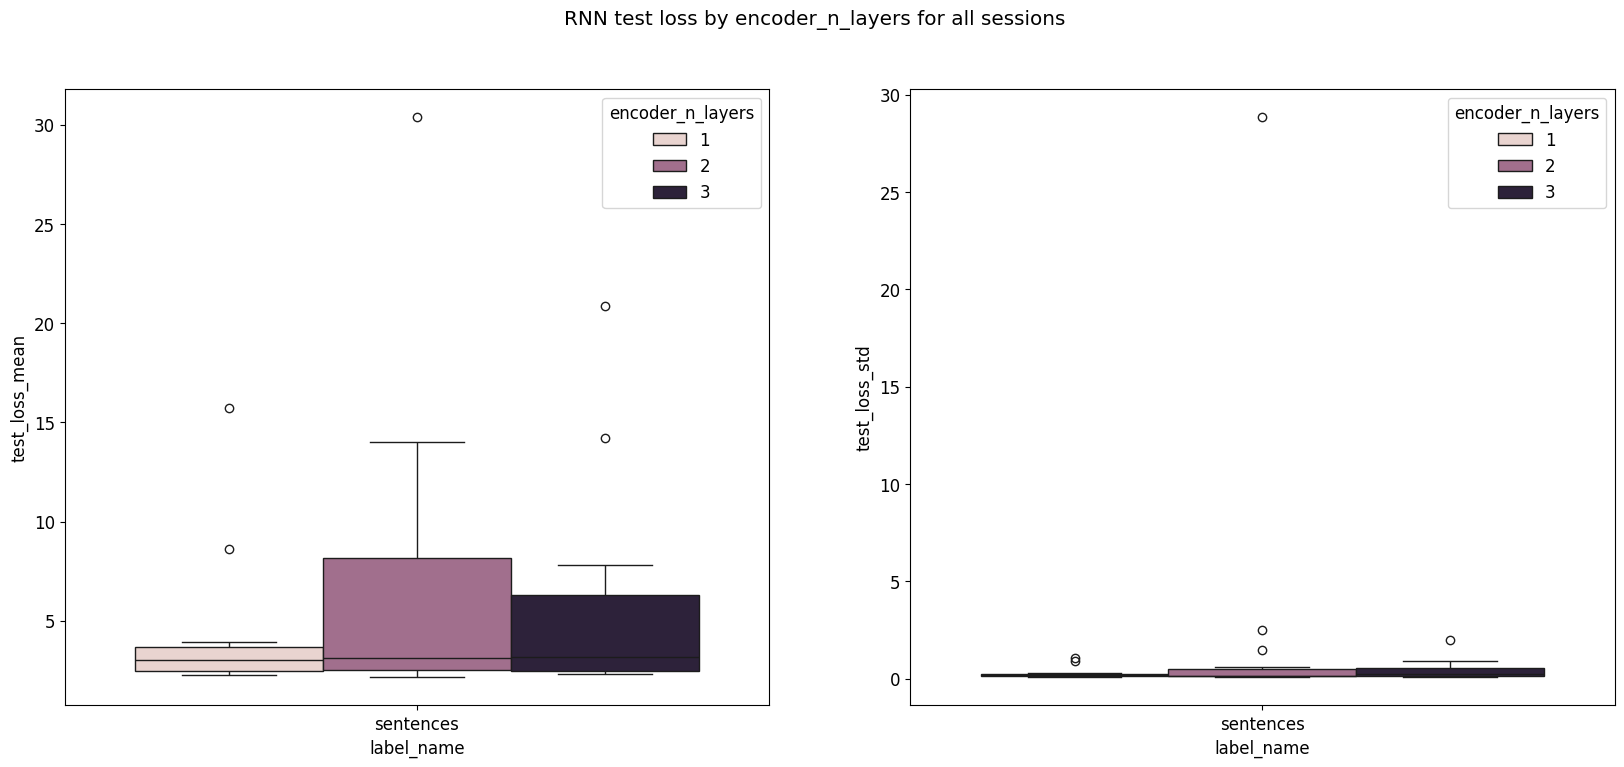

In [97]:
plot_hyperparameter_boxplots(results, "encoder_n_layers", "test", "loss", dir_prefix, label_names=["sentences"])

### TRF

In [98]:
model_name = "trf"
task_name = "seq_clf"
dir_prefix = f"{model_name}_{task_name}"
results = unify_results(path, dir_prefix=dir_prefix, label_names=["sentences"], limit_to_number=20)

In [99]:
df = get_best_values(dir_prefix, metric_name="mean_train_loss", additional_metrics=[], label_names=["sentences"], ascending=True)
df

session_id  sentences_mean_train_loss
0    20240708                   0.213286

<module 'matplotlib.pyplot' from '/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

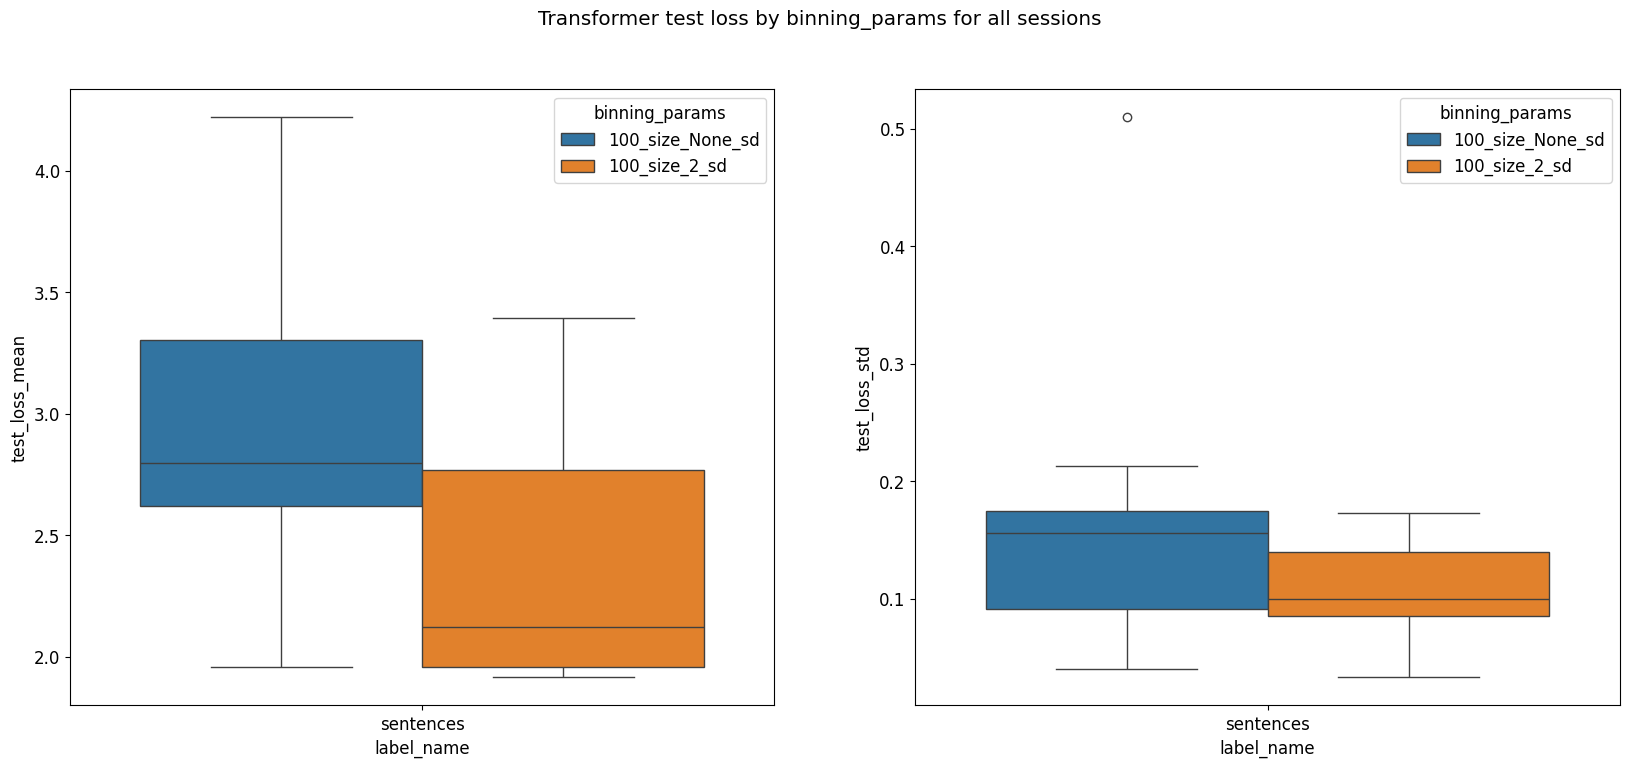

In [100]:
plot_hyperparameter_boxplots(results, "binning_params", "test", "loss", dir_prefix, label_names=["sentences"])

<module 'matplotlib.pyplot' from '/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

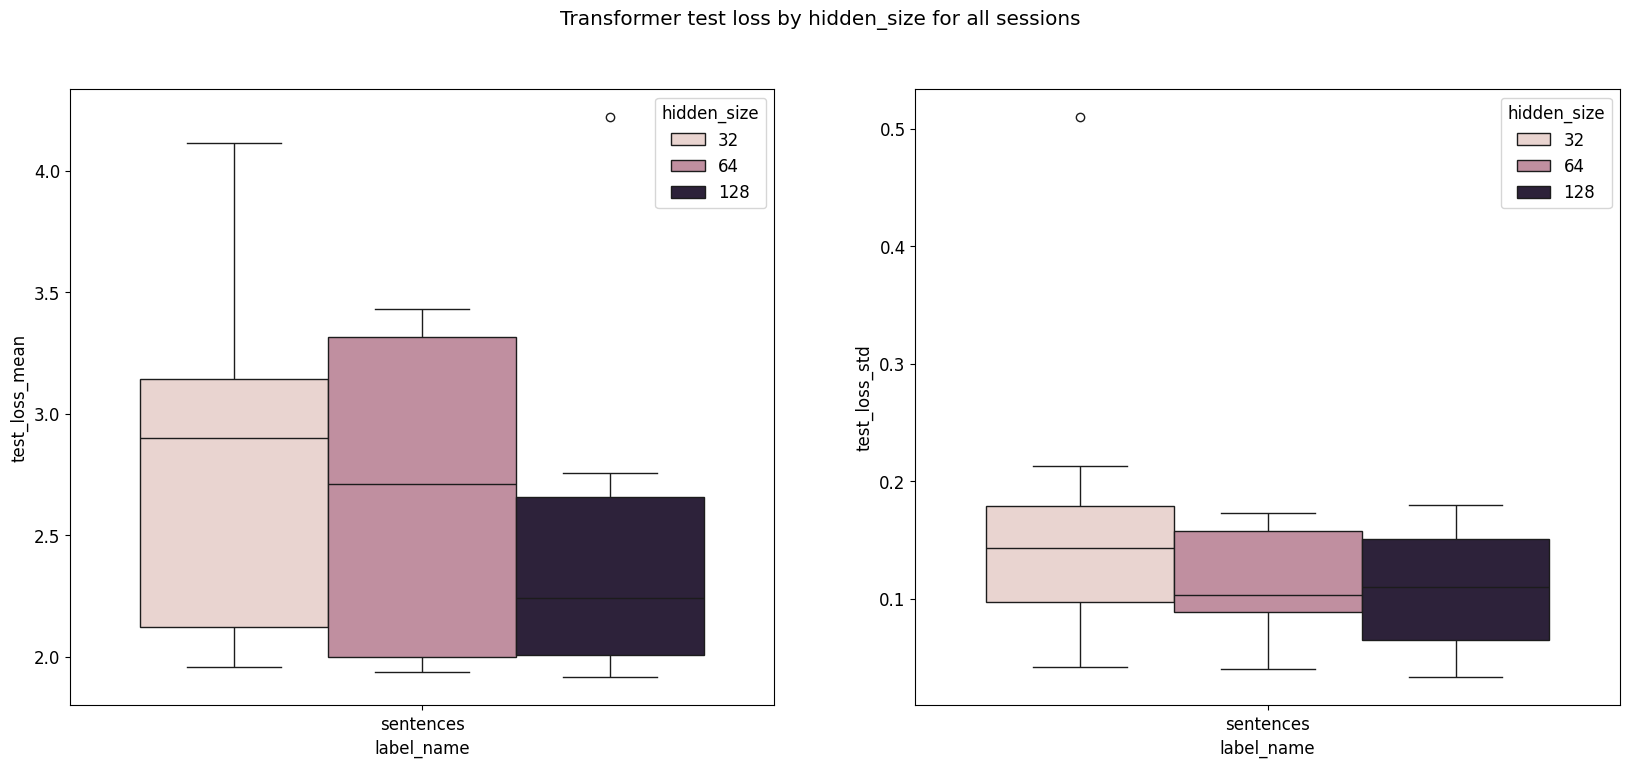

In [101]:
plot_hyperparameter_boxplots(results, "hidden_size", "test", "loss", dir_prefix, label_names=["sentences"])

<module 'matplotlib.pyplot' from '/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

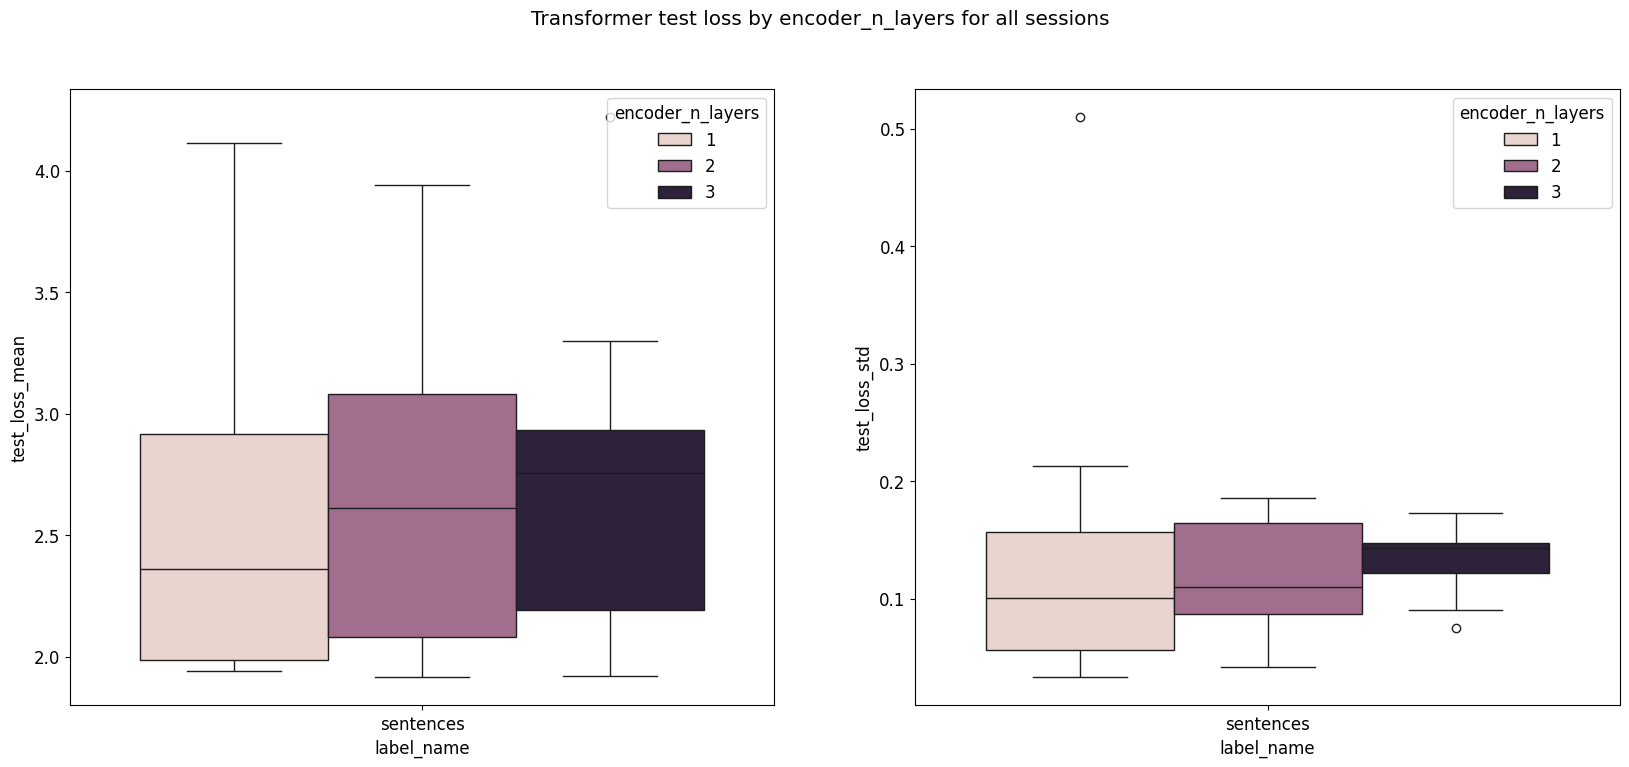

In [102]:
plot_hyperparameter_boxplots(results, "encoder_n_layers", "test", "loss", dir_prefix, label_names=["sentences"])

## Binning parameter boxplots

In [ ]:
limit_to_number = 10

clf_results = {}
reg_results = {}

for model_name in ["svm", "rnn", "trf"]:
    clf_results[model_name] = unify_results(path, dir_prefix=f"{model_name}_clf", limit_to_number=limit_to_number)
    reg_results[model_name] = unify_results(path, dir_prefix=f"{model_name}_reg", limit_to_number=limit_to_number)

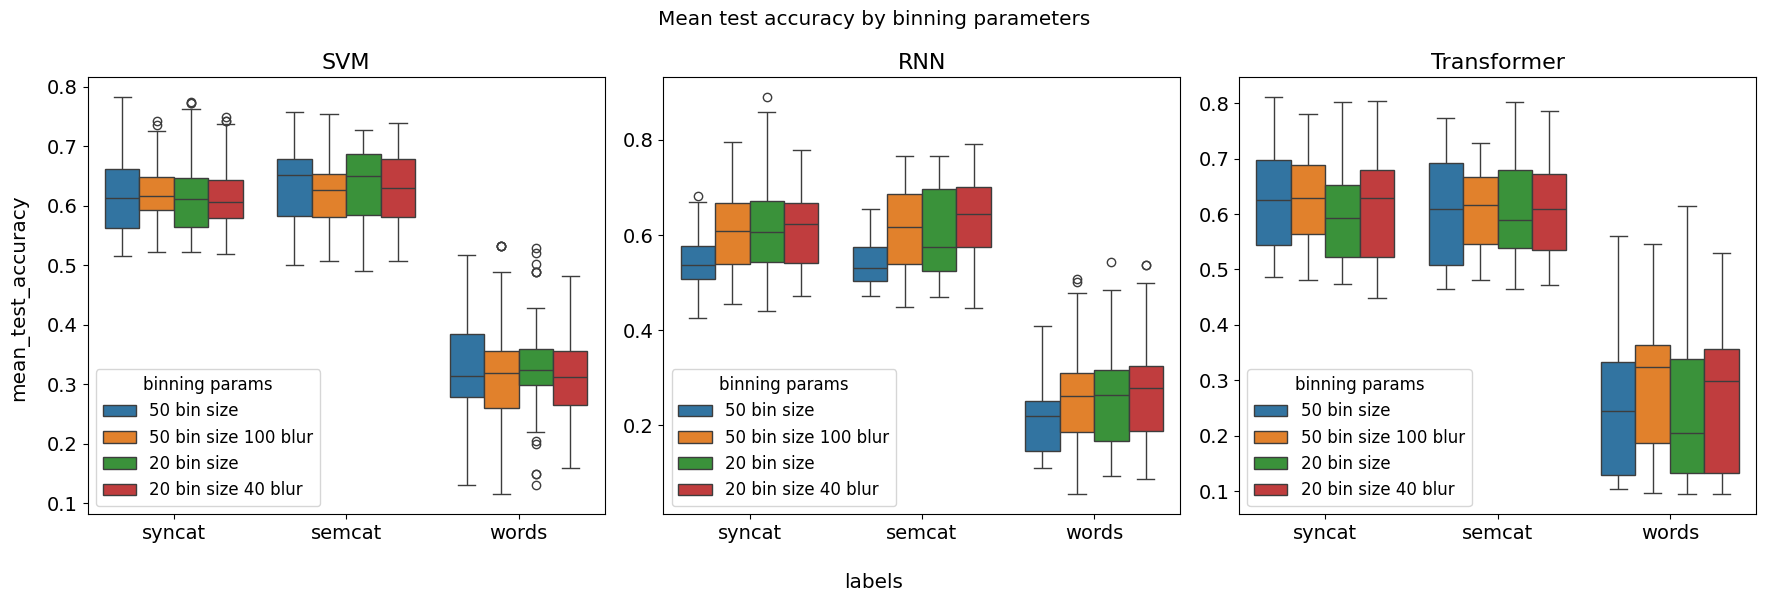

In [104]:
plot_binning_param_boxplots(clf_results, "clf", ["syncat_labels", "semcat_labels", "labels_words"])

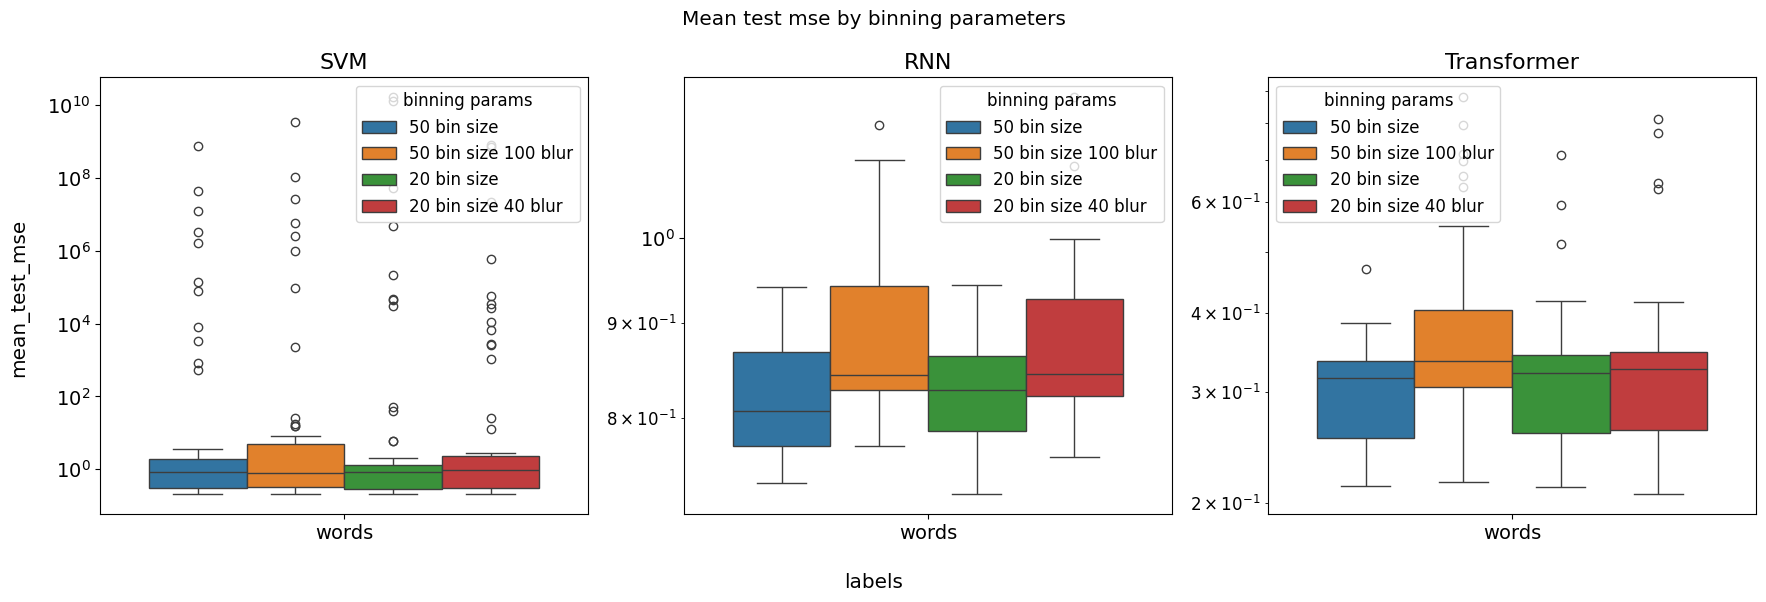

In [105]:
plot_binning_param_boxplots(reg_results, "reg", ["labels_words"], metric="mse", logscale=True)

## Histograms

In [106]:
clf_result_dicts = {}

label_names = ["syncat_labels", "semcat_labels", "labels_words"]

for model_type in ["svm", "rnn", "trf"]:
    dir_prefix = f"{model_type}_clf"
    clf_result_dicts[model_type] = unify_results(
        path, label_names=label_names, dir_prefix=dir_prefix, limit_to_number=10
    )

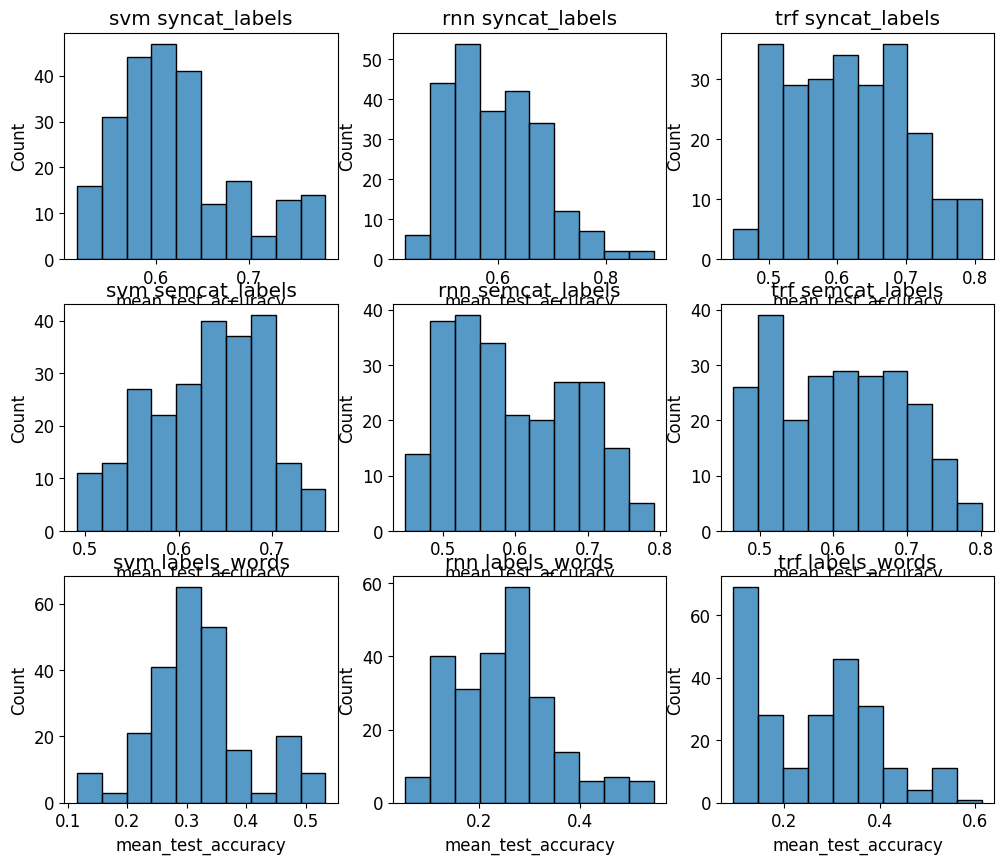

In [107]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

for label_name, row in zip(label_names, axs):

    for model_type, col in zip(["svm", "rnn", "trf"], row):
        sns.histplot(clf_result_dicts[f"{model_type}"][label_name]["mean_test_accuracy"], bins=10, ax=col)
        col.set_title(model_type + " " + label_name)

In [108]:
reg_result_dicts = {}

label_names=["labels_words"]

for model_type in ["svm", "rnn", "trf"]:
    dir_prefix = f"{model_type}_reg"
    reg_result_dicts[model_type] = unify_results(path, label_names=["labels_words"], dir_prefix=dir_prefix, limit_to_number=10)

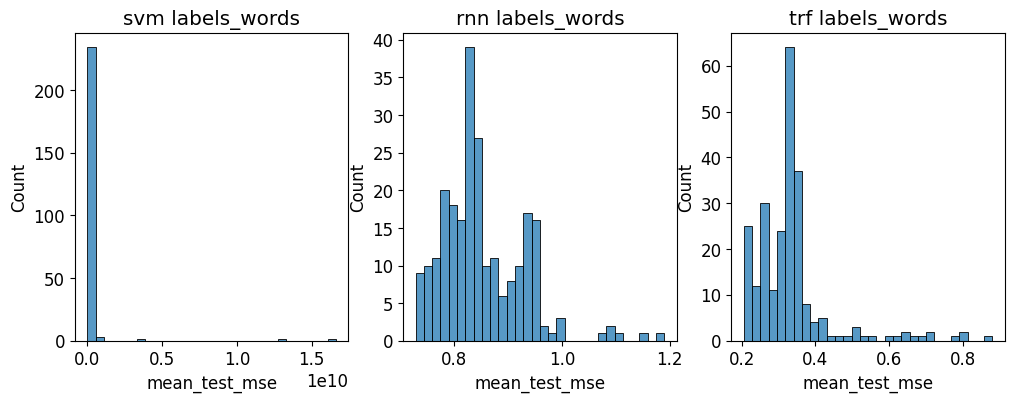

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for model_type, col in zip(["svm", "rnn", "trf"], axs):
        sns.histplot(reg_result_dicts[f"{model_type}"]["labels_words"]["mean_test_mse"], bins=30, ax=col)
        col.set_title(model_type + " " + label_name)

## Best model parameters
Create latex tables of the best model parameters as determined by the hyperparameter search.

In [9]:
BINNING_PARAM_REPORT_DICT = {"20_size_None_sd": "20ms",
                            "50_size_2_sd": "50ms / 100ms",
                            "20_size_2_sd": "20ms / 40ms",
                            "50_size_None_sd": "50ms",
                            "100_size_None_sd": "100ms"}

In [ ]:
def print_best_parameter_tables(task_type: str,
                                label_names: list[str],
                                metric: str,
                                ascending: bool = False,
                                limit_to_number: int = 10):


    for model_type in ["svm", "rnn", "trf"]:
        result_dict = unify_results(INPUT_DIR, label_names=label_names, dir_prefix=f"{model_type}_{task_type}", limit_to_number=limit_to_number)
        df_best_dict = get_best_parameter_dict(result_dict, quality_metric=metric, ascending=ascending)


        for label_name, df in df_best_dict.items():
            prefix = f"{model_type}_{task_type}"

            print(RELEVANT_PARAMETERS[prefix])
            
            df_best_dict[label_name] = df[["session_id", "binning_params"] + RELEVANT_PARAMETERS[prefix]]
            df_best_dict[label_name].loc[:, "binning_params"] = df_best_dict[label_name]["binning_params"].apply(lambda x: BINNING_PARAM_REPORT_DICT[x])
            print(model_type, task_type)
            print(label_name)
            print(df_best_dict[label_name].sort_values(by="session_id").to_latex(index=False,
                formatters={"name": str.upper},
                float_format="{:.5f}".format))


/home/michaela/Uni/refactoring_gitlab/thesis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-25 21:34:53.846322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 21:34:53.858426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748201693.880456   19999 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748201693.884340   1999

In [12]:
print_best_parameter_tables("clf", ["syncat_labels", "semcat_labels", "labels_words"], "mean_test_accuracy")

['C', 'gamma', 'kernel']
svm clf
syncat_labels
\begin{tabular}{rlrll}
\toprule
session_id & binning_params & C & gamma & kernel \\
\midrule
20221109 & 50ms & 5.70447 & 0.01 & rbf \\
20221114 & 20ms & 0.57230 & scale & rbf \\
20221116 & 50ms & 27.90181 & 0.0001 & rbf \\
20221117 & 50ms & 512.09198 & auto & rbf \\
20221121 & 50ms & 5.23812 & 0.001 & sigmoid \\
20221123 & 20ms & 10332.83482 & scale & rbf \\
\bottomrule
\end{tabular}

['C', 'gamma', 'kernel']
svm clf
semcat_labels
\begin{tabular}{rlrll}
\toprule
session_id & binning_params & C & gamma & kernel \\
\midrule
20221109 & 50ms & 13.46092 & auto & rbf \\
20221114 & 20ms / 40ms & 21.45541 & 0.0001 & rbf \\
20221116 & 50ms / 100ms & 189.34786 & scale & rbf \\
20221117 & 50ms & 530.07360 & auto & rbf \\
20221121 & 20ms & 15476.23025 & scale & rbf \\
20221123 & 20ms & 5.23099 & auto & sigmoid \\
\bottomrule
\end{tabular}

['C', 'gamma', 'kernel']
svm clf
labels_words
\begin{tabular}{rlrll}
\toprule
session_id & binning_params & C & g

In [13]:
print_best_parameter_tables("reg", ["labels_words"], "mean_test_mse", ascending=True)

['estimator__C', 'estimator__gamma', 'estimator__kernel']
svm reg
labels_words
\begin{tabular}{rlrll}
\toprule
session_id & binning_params & estimator__C & estimator__gamma & estimator__kernel \\
\midrule
20221109 & 20ms & 2.51807 & auto & rbf \\
20221114 & 20ms & NaN & NaN & NaN \\
20221116 & 50ms / 100ms & NaN & NaN & NaN \\
20221117 & 20ms / 40ms & 15769.74001 & scale & rbf \\
20221121 & 50ms / 100ms & NaN & NaN & NaN \\
20221123 & 50ms / 100ms & NaN & NaN & NaN \\
\bottomrule
\end{tabular}

['hidden_size', 'n_layers', 'batch_size', 'weight_decay', 'learning_rate', 'dropout']
rnn reg
labels_words
\begin{tabular}{rlrrrrrr}
\toprule
session_id & binning_params & hidden_size & n_layers & batch_size & weight_decay & learning_rate & dropout \\
\midrule
20221109 & 20ms & 256 & 2 & 128 & 0.00000 & 0.00569 & 0.34112 \\
20221114 & 20ms & 256 & 1 & 128 & 0.00100 & 0.00413 & 0.35891 \\
20221116 & 50ms & 128 & 2 & 128 & 0.00100 & 0.00636 & 0.21733 \\
20221117 & 50ms & 64 & 3 & 128 & 0.10000 & 0